<a href="https://colab.research.google.com/github/NeskaCleo/MonicaGlez/blob/main/Practica_final_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PRÁCTICA FINAL



Una empresa internacional relacionada con el sector de las telecomunicaciones quiere afianzarse nacionalmente. Para ello quiere fidelizar a sus clientes realizando acciones de crossselling. Cuenta con una base de datos con un total de 34 variables de clientes tomadas mensualmente. También saben qué clientes ha adquirido un producto en cada mes.

El objetivo que tienen es realizar un modelo con el que saber de manera más precisa qué clientes son más propensos a contratar un producto. Quieren realizar al menos dos modelos, uno de ellos con redes neuronales en Tensorflow. Además, les gustaría obtener una segmentación previa, de cara a dividir a sus clientes en dos grupos distintos y aplicar cada uno de los modelos anteriores a uno de los grupos.

Posteriormente a la realización de los modelos, piden que umbralices los outputs de los modelos. Nos dan Libertad para poner el umbral siempre que justifiquemos por qué ponemos ese umbral. Se valorarán análisis exploratorios que ayuden a entender el dataset de la empresa y tomar decisions.

Tareas a realizar:

El equipo de la empresa internacional te pide que les ayudes, pero no saben muy bien cómo abordar el problema, lo único que te pueden proporcionar son los datos. Aunque no saben cómo resolverlo, cuentan con dos data scientists en los que confían para que sirvan como interlocutores entre la empresa y tú. Deberás resolver las preguntas que tenga el/la data scientist que se te asigne. Además, te podrá hacer preguntas sobre conceptos de Machine Learning. Información de los datos: El dataset cuenta con 34 variables descriptivas X. El número total de muestras es de 20 mil clientes. Variables independientes X:

MB_TOTALES: mb totales consumidos por el cliente
FACTURACION_TOTAL_IMPUESTOS: facturación del cliente incluyendo impuestos
FACTURACION_CUOTA: facturación sólo de la cuota de los servicios
SEGUNDOS_LLAMADA_RED_PROPIA
SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA
SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA
MB_MENSUALES
EDAD: edad aproximada del cliente con un rango de error +-5
NUM_LLAMADAS_RED_PROPIA
FACTURACION_TOTAL_SIN_IMPUESTOS
NUM_LINEAS_PRIN_POSPAGO: líneas principales de contrato
NUM_LINEAS_POSPAGO
NUM_LINEAS_FIJAS
NUM_DIAS_CONVERGENTE: días que el cliente lleva con un fijo y un móvil
NUM_LINEAS_FIJAS_POSPAGO
NUM_SERVICIOS_POSPAGO
DIAS_PRIMERA_CUENTA: días desde primera cuenta en la empresa
NUM_CANCELACIONES
LLAMADAS_MOVILES
NUM_LINEAS_POSPAGO_TOTAL
TERMINO_FACTURACION
NUM_DESACTIVACIONES_FIJAS_POSPAGO
NUM_DESACTIVACIONES_FIJAS
NUM_LINEAS_TECNOLOGIA_DESCONOCIDA
NUM_DIAS_ACTIVO
MINUTOS_LLAMADAS_MENSUALES
NUM_DIAS_BUNDLE: número de días totales en el que el cliente ha tenido error en algún servicio
KPI_IMPUESTOS: impuestos de la factura principal del cliente
NUM_DESACTIVACIONES
PORCENTAJE_SEGUNDOS_RED_PROPIA
SERVICIOS_TOTALES_MARCA
SERVICIOS_TOTALES_POSPAGO
MINUTOS_LLAMADAS_MOVIL
PENETRACION_FIJO_ZONA: porcentaje de personas en la ciudad del cliente que tienen un fijo.
Variable independiente Y:

TARGET: variable que mide si el cliente el mes siguiente adquiere el producto (1) o no (0)
Variable temporal MES: Esta variable es el mes de los datos. Ej: si el mes de datos es 201906 y TARGET es 1, significa que ese cliente el mes de junio adquirió un producto

#Carga de librerías:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from IPython.core.display import display, HTML
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import os
import tensorflow as tf
from sklearn.decomposition import PCA
from scipy.stats import boxcox, probplot, norm, shapiro
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.cluster import KMeans
from datetime import date, datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import LocalOutlierFactor
from mpl_toolkits.mplot3d import Axes3D
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import warnings
warnings.filterwarnings('ignore')

#Definición de funciones:

In [ ]:
def comprueba_normalidad(df, return_type='axes', title='Comprobación de normalidad'):
    '''
    '''
    fig_tot = (len(df.columns))
    fig_por_fila = 3.
    tamanio_fig = 4.
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )
    plt.figure( figsize=( fig_por_fila*tamanio_fig+5, num_filas*tamanio_fig+2 ) )
    c = 0
    shapiro_test = {}
    lambdas = {}
    for i, col in enumerate(df.columns):
        ax = plt.subplot(num_filas, fig_por_fila, i+1)
        probplot(x = df[df.columns[i]], dist=norm, plot=ax)
        plt.title(df.columns[i])
        shapiro_test[df.columns[i]] = shapiro(df[df.columns[i]])
    plt.suptitle(title)
    plt.show()
    shapiro_test = pd.DataFrame(shapiro_test, index=['Test Statistic', 'p-value']).transpose()
    return shapiro_test

def relaciones_vs_target(X, Y, return_type='axes'):
    '''
    Función que representa gráficos de dispersión de las variables
    en X en función a la variable Y
    '''
    fig_tot = (len(X.columns))
    fig_por_fila = 5.
    tamanio_fig = 5.
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )
    plt.figure( figsize=( fig_por_fila*tamanio_fig+6, num_filas*tamanio_fig+6 ) )
    c = 0
    for i, col in enumerate(X.columns):
        plt.subplot(num_filas, fig_por_fila, i+1)
        sns.scatterplot(x=X[col], y=Y)
        plt.title( '%s vs %s' % (col, 'target') )
        plt.ylabel('Target')
        plt.xlabel(col)
    plt.show()

def represento_doble_hist(x_1, x_0, n_bins=11, title='', label_1='Clase 1',
                          label_0='Clase 0', normed=0):
    '''
    Función que recibe dos distribuciones de probabilidad y las representa
    en el mismo gráfico
    '''
    bins = n_bins
    plt.hist(x_1, bins, density = normed, alpha=0.5, label=label_1, color='red')
    plt.hist(x_0, bins, density = normed, alpha=0.5, label=label_0, color='green')
    plt.title(title)
    plt.legend(loc='best')

def hist_pos_neg_feat(x, y, normed=0, nbins=11, targets=(0,1)):
    '''
    Representa las variables en x divididas en dos distribuciones
    según su valor de y sea 1 o 0
    '''
    fig_tot = len(x.columns)
    fig_tot_fila = 4.; fig_tamanio = 4.
    num_filas = int( np.ceil(fig_tot/fig_tot_fila) )
    plt.figure( figsize=( fig_tot_fila*fig_tamanio+2, num_filas*fig_tamanio+2 ) )
    target_neg, target_pos = targets
    for i, feat in enumerate(x.columns):
        plt.subplot(num_filas, fig_tot_fila, i+1);
        plt.title('%s' % feat)
        idx_pos = y == target_pos
        idx_neg= y == target_neg
        represento_doble_hist(x[feat][idx_pos].values, x[feat][idx_neg].values, nbins,
                   normed = normed, title=('%s' % feat))

def represento_historico(historico):
    hist = pd.DataFrame(historico.history)
    hist['epoch'] = historico.epoch

    plt.figure(figsize=(15,7))
    plt.xlabel('Epoch')
    plt.ylabel('Error auc')
    plt.plot(hist['epoch'], hist['auc'],
           label='Error de entrenamiento')
    plt.plot(hist['epoch'], hist['val_auc'],
           label = 'Error de validación')
    plt.title('Error auc en entrenamiento y en test')
    plt.ylim([0,1])
    plt.legend()

def represento_doble_hist(x_1, x_0, n_bins=11, title='', label_1='Clase 1',
                          label_0='Clase 0', normed=0):
    '''
    Función que recibe dos distribuciones de probabilidad y las representa
    en el mismo gráfico
    '''
    bins = n_bins
    plt.hist(x_1, bins, density = normed, alpha=0.5, label=label_1, color='red')
    plt.hist(x_0, bins, density = normed, alpha=0.5, label=label_0, color='green')
    plt.title(title)
    plt.legend(loc='best')



#Lectura de datos:

In [ ]:
# Defino la lista de nombres de las variables
nombres_columnas = ['MES', 'MB_TOTALES', 'FACTURACION_TOTAL_IMPUESTOS', 'FACTURACION_CUOTA', 'SEGUNDOS_LLAMADA_RED_PROPIA',
                    'SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA', 'SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA', 'MB_MENSUALES', 'EDAD',
                    'NUM_LLAMADAS_RED_PROPIA', 'FACTURACION_TOTAL_SIN_IMPUESTOS', 'NUM_LINEAS_PRIN_POSPAGO', 'NUM_LINEAS_POSPAGO',
                    'NUM_LINEAS_FIJAS', 'NUM_DIAS_CONVERGENTE', 'NUM_LINEAS_FIJAS_POSPAGO', 'NUM_SERVICIOS_POSPAGO', 'DIAS_PRIMERA_CUENTA',
                    'NUM_CANCELACIONES', 'LLAMADAS_MOVILES', 'NUM_LINEAS_POSPAGO_TOTAL', 'TERMINO_FACTURACION', 'NUM_DESACTIVACIONES_FIJAS_POSPAGO',
                    'NUM_DESACTIVACIONES_FIJAS', 'NUM_LINEAS_TECNOLOGIA_DESCONOCIDA', 'NUM_DIAS_ACTIVO', 'MINUTOS_LLAMADAS_MENSUALES', 'NUM_DIAS_BUNDLE',
                    'KPI_IMPUESTOS', 'NUM_DESACTIVACIONES', 'PORCENTAJE_SEGUNDOS_RED_PROPIA', 'SERVICIOS_TOTALES_MARCA', 'SERVICIOS_TOTALES_POSPAGO',
                    'MINUTOS_LLAMADAS_MOVIL', 'PENETRACION_FIJO_ZONA']
# Leo el dataset, el cual tiene un separador especial... lo normal es encontrarse ficheros
# separados por ',' o por ';'
XY= pd.read_csv('/content/drive/MyDrive/datos_practica_small_20k_con_mes.csv', sep=',', names=nombres_columnas, index_col=False)

In [ ]:
XY = pd.read_csv('/content/drive/MyDrive/datos_practica_small_20k_con_mes.csv')
print(u'- El número de filas en el dataset es: {}'.format(XY.shape[0]))
print(u'- El número de columnas en el dataset es: {}'.format(XY.shape[1]))
print(u'- Los nombres de las variables independientes son: {}'.format(list(XY.columns)))
XY[:4]

- El número de filas en el dataset es: 20000
- El número de columnas en el dataset es: 36
- Los nombres de las variables independientes son: ['MES', 'MB_TOTALES', 'FACTURACION_TOTAL_IMPUESTOS', 'FACTURACION_CUOTA', 'SEGUNDOS_LLAMADA_RED_PROPIA', 'SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA', 'SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA', 'MB_MENSUALES', 'EDAD', 'NUM_LLAMADAS_RED_PROPIA', 'FACTURACION_TOTAL_SIN_IMPUESTOS', 'NUM_LINEAS_PRIN_POSPAGO', 'NUM_LINEAS_POSPAGO', 'NUM_LINEAS_FIJAS', 'NUM_DIAS_CONVERGENTE', 'NUM_LINEAS_FIJAS_POSPAGO', 'NUM_SERVICIOS_POSPAGO', 'DIAS_PRIMERA_CUENTA', 'NUM_CANCELACIONES', 'LLAMADAS_MOVILES', 'NUM_LINEAS_POSPAGO_TOTAL', 'TERMINO_FACTURACION', 'NUM_DESACTIVACIONES_FIJAS_POSPAGO', 'NUM_DESACTIVACIONES_FIJAS', 'NUM_LINEAS_TECNOLOGIA_DESCONOCIDA', 'NUM_DIAS_ACTIVO', 'MINUTOS_LLAMADAS_MENSUALES', 'NUM_DIAS_BUNDLE', 'KPI_IMPUESTOS', 'NUM_DESACTIVACIONES', 'PORCENTAJE_SEGUNDOS_RED_PROPIA', 'SERVICIOS_TOTALES_MARCA', 'SERVICIOS_TOTALES_POSPAGO', 'MINUTOS_LLAMADAS_MOVIL', 

,MES,MB_TOTALES,FACTURACION_TOTAL_IMPUESTOS,FACTURACION_CUOTA,SEGUNDOS_LLAMADA_RED_PROPIA,SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,MB_MENSUALES,EDAD,NUM_LLAMADAS_RED_PROPIA,...,MINUTOS_LLAMADAS_MENSUALES,NUM_DIAS_BUNDLE,KPI_IMPUESTOS,NUM_DESACTIVACIONES,PORCENTAJE_SEGUNDOS_RED_PROPIA,SERVICIOS_TOTALES_MARCA,SERVICIOS_TOTALES_POSPAGO,MINUTOS_LLAMADAS_MOVIL,PENETRACION_FIJO_ZONA,TARGET
0,201901,232.121597,10.186000,0.000000,4523.0,1183.0,28.0,232.121597,39.0,54.0,...,21.683399,0,1.767800,0,100.0,2,1,0.0,0.264612,0
1,201911,18280.292969,32.005001,26.450001,13288.0,9194.0,49.0,18280.292969,25.0,152.0,...,166.050007,435,5.555000,0,100.0,1,2,0.0,0.380171,0
2,201906,2141.692810,37.442001,31.400000,13.0,13.0,0.0,2141.692810,47.0,4.0,...,108.850102,0,2.042002,0,100.0,2,2,0.0,0.156041,0
3,202006,3181.986496,20.001000,16.530000,0.0,0.0,0.0,3181.986496,43.0,0.0,...,65.799899,0,3.471001,0,100.0,2,3,0.0,0.228810,1


#Preprocesamiento:

In [ ]:
XY.isnull().sum()

MES                                        0
MB_TOTALES                               259
FACTURACION_TOTAL_IMPUESTOS               76
FACTURACION_CUOTA                         76
SEGUNDOS_LLAMADA_RED_PROPIA              157
SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA     157
SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA     157
MB_MENSUALES                             251
EDAD                                      29
NUM_LLAMADAS_RED_PROPIA                  157
FACTURACION_TOTAL_SIN_IMPUESTOS           76
NUM_LINEAS_PRIN_POSPAGO                    0
NUM_LINEAS_POSPAGO                         0
NUM_LINEAS_FIJAS                           0
NUM_DIAS_CONVERGENTE                       0
NUM_LINEAS_FIJAS_POSPAGO                   0
NUM_SERVICIOS_POSPAGO                      0
DIAS_PRIMERA_CUENTA                        0
NUM_CANCELACIONES                          0
LLAMADAS_MOVILES                          82
NUM_LINEAS_POSPAGO_TOTAL                   0
TERMINO_FACTURACION                       76
NUM_DESACT

In [ ]:
XY.dropna(subset=['MB_TOTALES'],inplace=True)

In [ ]:
XY.isnull().sum()

MES                                        0
MB_TOTALES                                 0
FACTURACION_TOTAL_IMPUESTOS                0
FACTURACION_CUOTA                          0
SEGUNDOS_LLAMADA_RED_PROPIA               52
SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA      52
SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA      52
MB_MENSUALES                               0
EDAD                                      28
NUM_LLAMADAS_RED_PROPIA                   52
FACTURACION_TOTAL_SIN_IMPUESTOS            0
NUM_LINEAS_PRIN_POSPAGO                    0
NUM_LINEAS_POSPAGO                         0
NUM_LINEAS_FIJAS                           0
NUM_DIAS_CONVERGENTE                       0
NUM_LINEAS_FIJAS_POSPAGO                   0
NUM_SERVICIOS_POSPAGO                      0
DIAS_PRIMERA_CUENTA                        0
NUM_CANCELACIONES                          0
LLAMADAS_MOVILES                           0
NUM_LINEAS_POSPAGO_TOTAL                   0
TERMINO_FACTURACION                        0
NUM_DESACT

In [ ]:
XY.dropna(subset=['SEGUNDOS_LLAMADA_RED_PROPIA'],inplace=True)

In [ ]:
XY.isnull().sum()

MES                                        0
MB_TOTALES                                 0
FACTURACION_TOTAL_IMPUESTOS                0
FACTURACION_CUOTA                          0
SEGUNDOS_LLAMADA_RED_PROPIA                0
SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA       0
SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA       0
MB_MENSUALES                               0
EDAD                                      28
NUM_LLAMADAS_RED_PROPIA                    0
FACTURACION_TOTAL_SIN_IMPUESTOS            0
NUM_LINEAS_PRIN_POSPAGO                    0
NUM_LINEAS_POSPAGO                         0
NUM_LINEAS_FIJAS                           0
NUM_DIAS_CONVERGENTE                       0
NUM_LINEAS_FIJAS_POSPAGO                   0
NUM_SERVICIOS_POSPAGO                      0
DIAS_PRIMERA_CUENTA                        0
NUM_CANCELACIONES                          0
LLAMADAS_MOVILES                           0
NUM_LINEAS_POSPAGO_TOTAL                   0
TERMINO_FACTURACION                        0
NUM_DESACT

In [ ]:
XY.describe()

,MES,MB_TOTALES,FACTURACION_TOTAL_IMPUESTOS,FACTURACION_CUOTA,SEGUNDOS_LLAMADA_RED_PROPIA,SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,MB_MENSUALES,EDAD,NUM_LLAMADAS_RED_PROPIA,...,MINUTOS_LLAMADAS_MENSUALES,NUM_DIAS_BUNDLE,KPI_IMPUESTOS,NUM_DESACTIVACIONES,PORCENTAJE_SEGUNDOS_RED_PROPIA,SERVICIOS_TOTALES_MARCA,SERVICIOS_TOTALES_POSPAGO,MINUTOS_LLAMADAS_MOVIL,PENETRACION_FIJO_ZONA,TARGET
count,19689.000000,19689.000000,19689.000000,19689.000000,19689.000000,19689.000000,19689.000000,19689.000000,19661.000000,19689.000000,...,19689.000000,19689.000000,19689.000000,19689.000000,19623.000000,19689.000000,19689.000000,19689.000000,18408.000000,19689.000000
mean,201948.494540,12316.036095,41.100347,25.309019,19430.154807,10414.266240,63.419066,12301.683523,43.936677,157.492001,...,362.901264,146.042968,5.688149,0.007974,99.975073,1.438722,1.798009,0.923629,0.256870,0.314338
std,49.260956,20066.588268,29.123713,13.052613,31852.978924,19024.609593,93.729656,20066.443407,14.080618,228.453898,...,543.860967,469.114073,3.554876,0.105166,1.287992,0.760819,1.330107,30.608885,0.072974,0.464263
min,201901.000000,0.000000,-0.002000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,...,0.000000,0.000000,-1.190000,0.000000,0.000000,1.000000,0.000000,0.000000,0.039562,0.000000
25%,201905.000000,1949.110229,24.999001,15.700000,1876.000000,741.000000,12.000000,1941.586426,33.000000,30.000000,...,65.883299,0.000000,3.300498,0.000000,100.000000,1.000000,1.000000,0.000000,0.199451,0.000000
50%,201911.000000,5945.542480,33.118001,23.969999,8145.000000,3702.000000,36.000000,5931.522949,43.000000,88.000000,...,179.850004,1.000000,5.038001,0.000000,100.000000,1.000000,1.000000,0.000000,0.261877,0.000000
75%,202005.000000,16038.484375,50.426000,27.270000,23217.000000,11987.000000,82.000000,16004.707581,54.000000,200.000000,...,444.983312,2.000000,6.768002,0.000000,100.000000,2.000000,2.000000,0.000000,0.296955,1.000000
max,202011.000000,853613.593750,1116.636004,133.890000,584239.000000,422724.000000,6220.000000,853613.593750,98.000000,12497.000000,...,12316.250395,4056.000000,93.483509,4.000000,100.000000,8.000000,18.000000,2089.316758,0.380171,1.000000


In [ ]:
XY['PENETRACION_FIJO_ZONA'] = XY['PENETRACION_FIJO_ZONA'].fillna(0.256870)
XY['EDAD'] = XY['EDAD'].fillna(43.936677)
XY['PORCENTAJE_SEGUNDOS_RED_PROPIA'] = XY['PORCENTAJE_SEGUNDOS_RED_PROPIA'].fillna(99.975073)

In [ ]:
XY['NUM_DIAS_ACTIVO'].describe()

count    19141.000000
mean      1261.163367
std        938.213935
min          0.000000
25%        498.000000
50%       1055.000000
75%       1872.000000
max       4959.000000
Name: NUM_DIAS_ACTIVO, dtype: float64

In [ ]:
XY['NUM_DIAS_ACTIVO'] = XY['NUM_DIAS_ACTIVO'].fillna(1261.163367)

In [ ]:
XY.select_dtypes(exclude=['number']).columns

Index([], dtype='object')

In [ ]:
XY

,MES,MB_TOTALES,FACTURACION_TOTAL_IMPUESTOS,FACTURACION_CUOTA,SEGUNDOS_LLAMADA_RED_PROPIA,SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,MB_MENSUALES,EDAD,NUM_LLAMADAS_RED_PROPIA,...,MINUTOS_LLAMADAS_MENSUALES,NUM_DIAS_BUNDLE,KPI_IMPUESTOS,NUM_DESACTIVACIONES,PORCENTAJE_SEGUNDOS_RED_PROPIA,SERVICIOS_TOTALES_MARCA,SERVICIOS_TOTALES_POSPAGO,MINUTOS_LLAMADAS_MOVIL,PENETRACION_FIJO_ZONA,TARGET
0,201901,232.121597,10.186000,0.000000,4523.0,1183.0,28.0,232.121597,39.0,54.0,...,21.683399,0,1.767800,0,100.0,2,1,0.0,0.264612,0
1,201911,18280.292969,32.005001,26.450001,13288.0,9194.0,49.0,18280.292969,25.0,152.0,...,166.050007,435,5.555000,0,100.0,1,2,0.0,0.380171,0
2,201906,2141.692810,37.442001,31.400000,13.0,13.0,0.0,2141.692810,47.0,4.0,...,108.850102,0,2.042002,0,100.0,2,2,0.0,0.156041,0
3,202006,3181.986496,20.001000,16.530000,0.0,0.0,0.0,3181.986496,43.0,0.0,...,65.799899,0,3.471001,0,100.0,2,3,0.0,0.228810,1
4,202001,25626.083984,37.005001,26.450001,72783.0,27609.0,151.0,25626.083984,40.0,329.0,...,519.683305,1,5.555000,0,100.0,1,1,0.0,0.210286,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,202006,20431.367188,21.640001,16.530001,8226.0,4699.0,61.0,20431.367188,39.0,163.0,...,123.550202,1063,3.756000,0,100.0,1,2,0.0,0.180917,1
19996,202010,2717.812500,36.593000,23.969999,22401.0,7645.0,33.0,2717.812500,70.0,87.0,...,124.883500,0,6.351001,0,100.0,1,1,0.0,0.171539,1
19997,202007,21.569700,9.544000,0.000000,1.0,1.0,0.0,21.569700,52.0,1.0,...,6.500000,0,1.656100,0,100.0,1,1,0.0,0.201103,0
19998,202007,16230.392578,32.005001,26.450001,3545.0,2600.0,8.0,16230.392578,40.0,36.0,...,241.733403,1,5.555000,0,100.0,1,1,0.0,0.274430,1


In [ ]:
XY['MES'] = pd.to_datetime(XY['MES'], format ='%Y%m')
XY[4: ]
XY.dtypes

MES                                     datetime64[ns]
MB_TOTALES                                     float64
FACTURACION_TOTAL_IMPUESTOS                    float64
FACTURACION_CUOTA                              float64
SEGUNDOS_LLAMADA_RED_PROPIA                    float64
SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA           float64
SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA           float64
MB_MENSUALES                                   float64
EDAD                                           float64
NUM_LLAMADAS_RED_PROPIA                        float64
FACTURACION_TOTAL_SIN_IMPUESTOS                float64
NUM_LINEAS_PRIN_POSPAGO                          int64
NUM_LINEAS_POSPAGO                               int64
NUM_LINEAS_FIJAS                                 int64
NUM_DIAS_CONVERGENTE                             int64
NUM_LINEAS_FIJAS_POSPAGO                         int64
NUM_SERVICIOS_POSPAGO                            int64
DIAS_PRIMERA_CUENTA                              int64
NUM_CANCEL

In [ ]:
A = 2019 # año bisiesto arbitrario, por si la fecha es un 29 de febrero
estaciones = [('Invierno', date(A,  1,  1),  date(A,  3, 1)),
              ('Primavera', date(A,  4, 1),  date(A,  6, 1)),
             ('Verano', date(A,  7, 1),  date(A,  9, 1)),
             ('Otoño', date(A,  10, 1),  date(A, 12, 1)),
              ('Invierno', date(A+1,  1,  1),  date(A+1,  3, 1)),
              ('Primavera', date(A+1,  4, 1),  date(A+1,  6, 1)),
             ('Verano', date(A+1,  7, 1),  date(A+1,  9, 1)),
             ('Otoño', date(A+1,  10, 1),  date(A+1, 12, 1))]

estaciones

[('Invierno', datetime.date(2019, 1, 1), datetime.date(2019, 3, 1)),
 ('Primavera', datetime.date(2019, 4, 1), datetime.date(2019, 6, 1)),
 ('Verano', datetime.date(2019, 7, 1), datetime.date(2019, 9, 1)),
 ('Otoño', datetime.date(2019, 10, 1), datetime.date(2019, 12, 1)),
 ('Invierno', datetime.date(2020, 1, 1), datetime.date(2020, 3, 1)),
 ('Primavera', datetime.date(2020, 4, 1), datetime.date(2020, 6, 1)),
 ('Verano', datetime.date(2020, 7, 1), datetime.date(2020, 9, 1)),
 ('Otoño', datetime.date(2020, 10, 1), datetime.date(2020, 12, 1))]

In [ ]:
def get_season(fila):
    for estacion, inicio, fin in estaciones:
      if inicio <= fila['MES'] <= fin:
       return estacion
#X.apply(get_season, axis=1 )
XY ['ESTACION'] = XY.apply(get_season, axis=1 )


In [ ]:
XY = pd.get_dummies(XY,columns=['ESTACION'],drop_first=True)
XY[:3]

,MES,MB_TOTALES,FACTURACION_TOTAL_IMPUESTOS,FACTURACION_CUOTA,SEGUNDOS_LLAMADA_RED_PROPIA,SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,MB_MENSUALES,EDAD,NUM_LLAMADAS_RED_PROPIA,...,NUM_DESACTIVACIONES,PORCENTAJE_SEGUNDOS_RED_PROPIA,SERVICIOS_TOTALES_MARCA,SERVICIOS_TOTALES_POSPAGO,MINUTOS_LLAMADAS_MOVIL,PENETRACION_FIJO_ZONA,TARGET,ESTACION_Otoño,ESTACION_Primavera,ESTACION_Verano
0,2019-01-01,232.121597,10.186000,0.000000,4523.0,1183.0,28.0,232.121597,39.0,54.0,...,0,100.0,2,1,0.0,0.264612,0,0,0,0
1,2019-11-01,18280.292969,32.005001,26.450001,13288.0,9194.0,49.0,18280.292969,25.0,152.0,...,0,100.0,1,2,0.0,0.380171,0,1,0,0
2,2019-06-01,2141.692810,37.442001,31.400000,13.0,13.0,0.0,2141.692810,47.0,4.0,...,0,100.0,2,2,0.0,0.156041,0,0,1,0


In [ ]:
XY0 = XY.drop(['MES'],axis=1)

In [ ]:
XY0

,MB_TOTALES,FACTURACION_TOTAL_IMPUESTOS,FACTURACION_CUOTA,SEGUNDOS_LLAMADA_RED_PROPIA,SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,MB_MENSUALES,EDAD,NUM_LLAMADAS_RED_PROPIA,FACTURACION_TOTAL_SIN_IMPUESTOS,...,NUM_DESACTIVACIONES,PORCENTAJE_SEGUNDOS_RED_PROPIA,SERVICIOS_TOTALES_MARCA,SERVICIOS_TOTALES_POSPAGO,MINUTOS_LLAMADAS_MOVIL,PENETRACION_FIJO_ZONA,TARGET,ESTACION_Otoño,ESTACION_Primavera,ESTACION_Verano
0,232.121597,10.186000,0.000000,4523.0,1183.0,28.0,232.121597,39.0,54.0,8.418200,...,0,100.0,2,1,0.0,0.264612,0,0,0,0
1,18280.292969,32.005001,26.450001,13288.0,9194.0,49.0,18280.292969,25.0,152.0,26.450001,...,0,100.0,1,2,0.0,0.380171,0,1,0,0
2,2141.692810,37.442001,31.400000,13.0,13.0,0.0,2141.692810,47.0,4.0,35.400000,...,0,100.0,2,2,0.0,0.156041,0,0,1,0
3,3181.986496,20.001000,16.530000,0.0,0.0,0.0,3181.986496,43.0,0.0,16.530000,...,0,100.0,2,3,0.0,0.228810,1,0,1,0
4,25626.083984,37.005001,26.450001,72783.0,27609.0,151.0,25626.083984,40.0,329.0,31.450001,...,0,100.0,1,1,0.0,0.210286,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,20431.367188,21.640001,16.530001,8226.0,4699.0,61.0,20431.367188,39.0,163.0,17.884001,...,0,100.0,1,2,0.0,0.180917,1,0,1,0
19996,2717.812500,36.593000,23.969999,22401.0,7645.0,33.0,2717.812500,70.0,87.0,30.241999,...,0,100.0,1,1,0.0,0.171539,1,1,0,0
19997,21.569700,9.544000,0.000000,1.0,1.0,0.0,21.569700,52.0,1.0,7.887900,...,0,100.0,1,1,0.0,0.201103,0,0,0,1
19998,16230.392578,32.005001,26.450001,3545.0,2600.0,8.0,16230.392578,40.0,36.0,26.450001,...,0,100.0,1,1,0.0,0.274430,1,0,0,1


##Division en features X + target Y

In [ ]:
X0 = XY0.drop('TARGET', axis=1)
Y0 = XY0['TARGET']

In [ ]:
X_normalizado = (X0-X0.mean())/XY0.std()

In [ ]:
X_normalizado[:2]

,DIAS_PRIMERA_CUENTA,EDAD,ESTACION_Otoño,ESTACION_Primavera,ESTACION_Verano,FACTURACION_CUOTA,FACTURACION_TOTAL_IMPUESTOS,FACTURACION_TOTAL_SIN_IMPUESTOS,KPI_IMPUESTOS,LLAMADAS_MOVILES,...,NUM_SERVICIOS_POSPAGO,PENETRACION_FIJO_ZONA,PORCENTAJE_SEGUNDOS_RED_PROPIA,SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,SEGUNDOS_LLAMADA_RED_PROPIA,SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,SERVICIOS_TOTALES_MARCA,SERVICIOS_TOTALES_POSPAGO,TARGET,TERMINO_FACTURACION
0,-1.371928,-0.350850,-0.495396,-0.605952,-0.588733,-1.939000,-1.061484,-1.024628,-1.102809,-0.035665,...,-0.54721,0.109723,0.019386,-0.377885,-0.467999,-0.485228,0.737728,-0.599959,NaN,-0.434787
1,-1.002330,-1.345833,2.018484,-0.605952,-0.588733,0.087414,-0.312300,-0.340184,-0.037455,-0.035665,...,-0.54721,1.747452,0.019386,-0.153837,-0.192828,-0.064141,-0.576644,0.151861,NaN,-0.434787


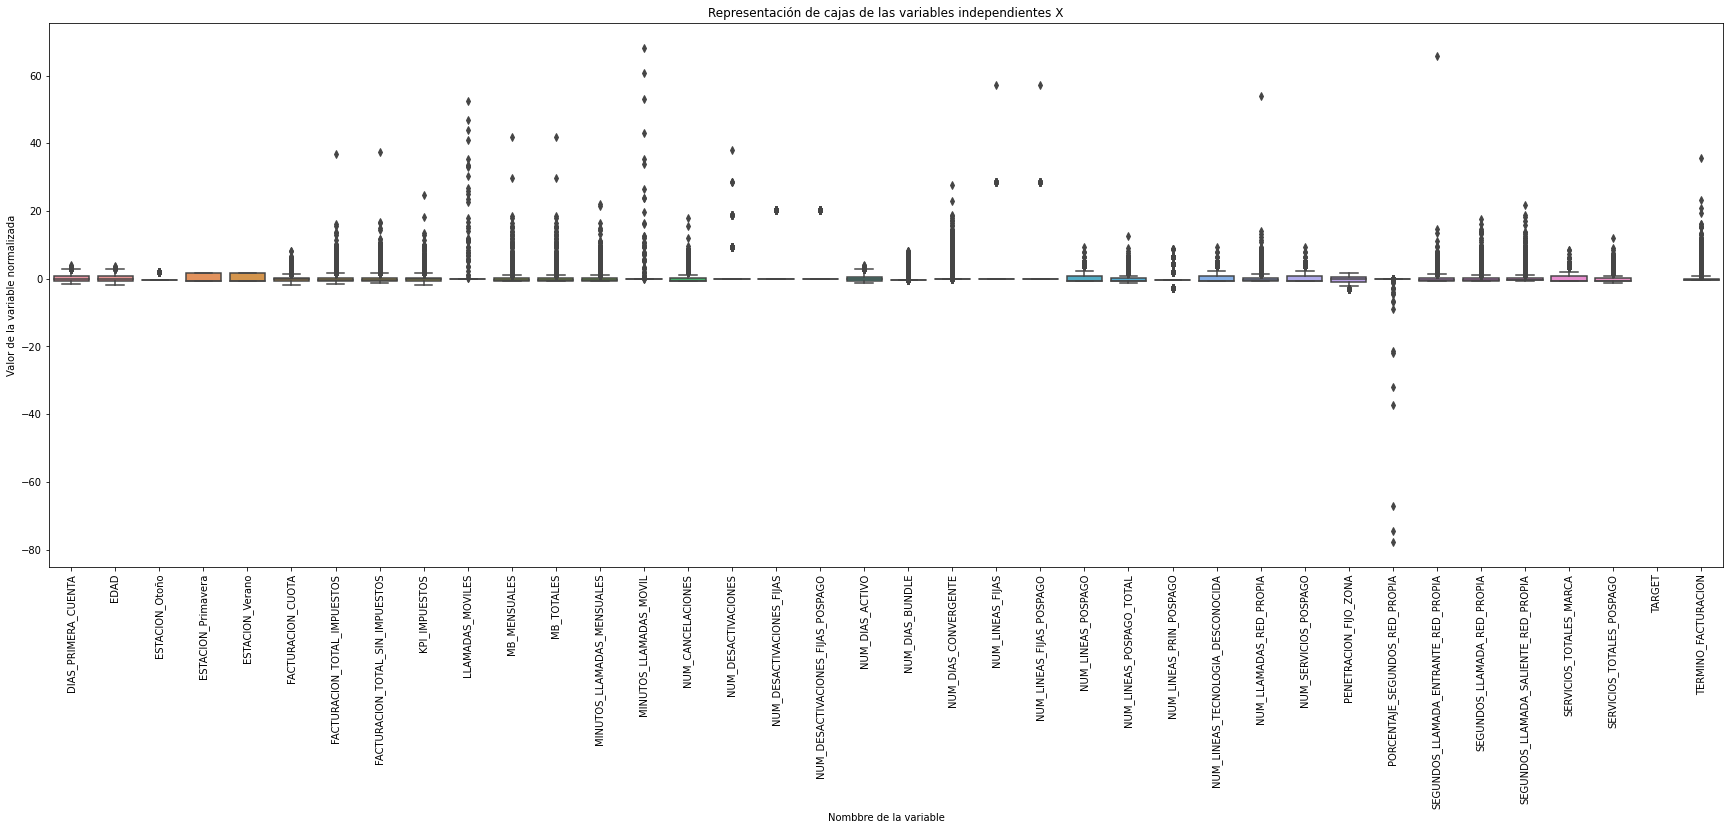

In [ ]:
plt.figure(figsize=(30,10))
ax = sns.boxplot(data=X_normalizado)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(u'Representación de cajas de las variables independientes X')
plt.ylabel('Valor de la variable normalizada')
_ = plt.xlabel('Nombbre de la variable')

##Histogramas

In [ ]:
X0.columns

Index(['MB_TOTALES', 'FACTURACION_TOTAL_IMPUESTOS', 'FACTURACION_CUOTA',
       'SEGUNDOS_LLAMADA_RED_PROPIA', 'SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA',
       'SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA', 'MB_MENSUALES', 'EDAD',
       'NUM_LLAMADAS_RED_PROPIA', 'FACTURACION_TOTAL_SIN_IMPUESTOS',
       'NUM_LINEAS_PRIN_POSPAGO', 'NUM_LINEAS_POSPAGO', 'NUM_LINEAS_FIJAS',
       'NUM_DIAS_CONVERGENTE', 'NUM_LINEAS_FIJAS_POSPAGO',
       'NUM_SERVICIOS_POSPAGO', 'DIAS_PRIMERA_CUENTA', 'NUM_CANCELACIONES',
       'LLAMADAS_MOVILES', 'NUM_LINEAS_POSPAGO_TOTAL', 'TERMINO_FACTURACION',
       'NUM_DESACTIVACIONES_FIJAS_POSPAGO', 'NUM_DESACTIVACIONES_FIJAS',
       'NUM_LINEAS_TECNOLOGIA_DESCONOCIDA', 'NUM_DIAS_ACTIVO',
       'MINUTOS_LLAMADAS_MENSUALES', 'NUM_DIAS_BUNDLE', 'KPI_IMPUESTOS',
       'NUM_DESACTIVACIONES', 'PORCENTAJE_SEGUNDOS_RED_PROPIA',
       'SERVICIOS_TOTALES_MARCA', 'SERVICIOS_TOTALES_POSPAGO',
       'MINUTOS_LLAMADAS_MOVIL', 'PENETRACION_FIJO_ZONA', 'ESTACION_Otoño',
       '

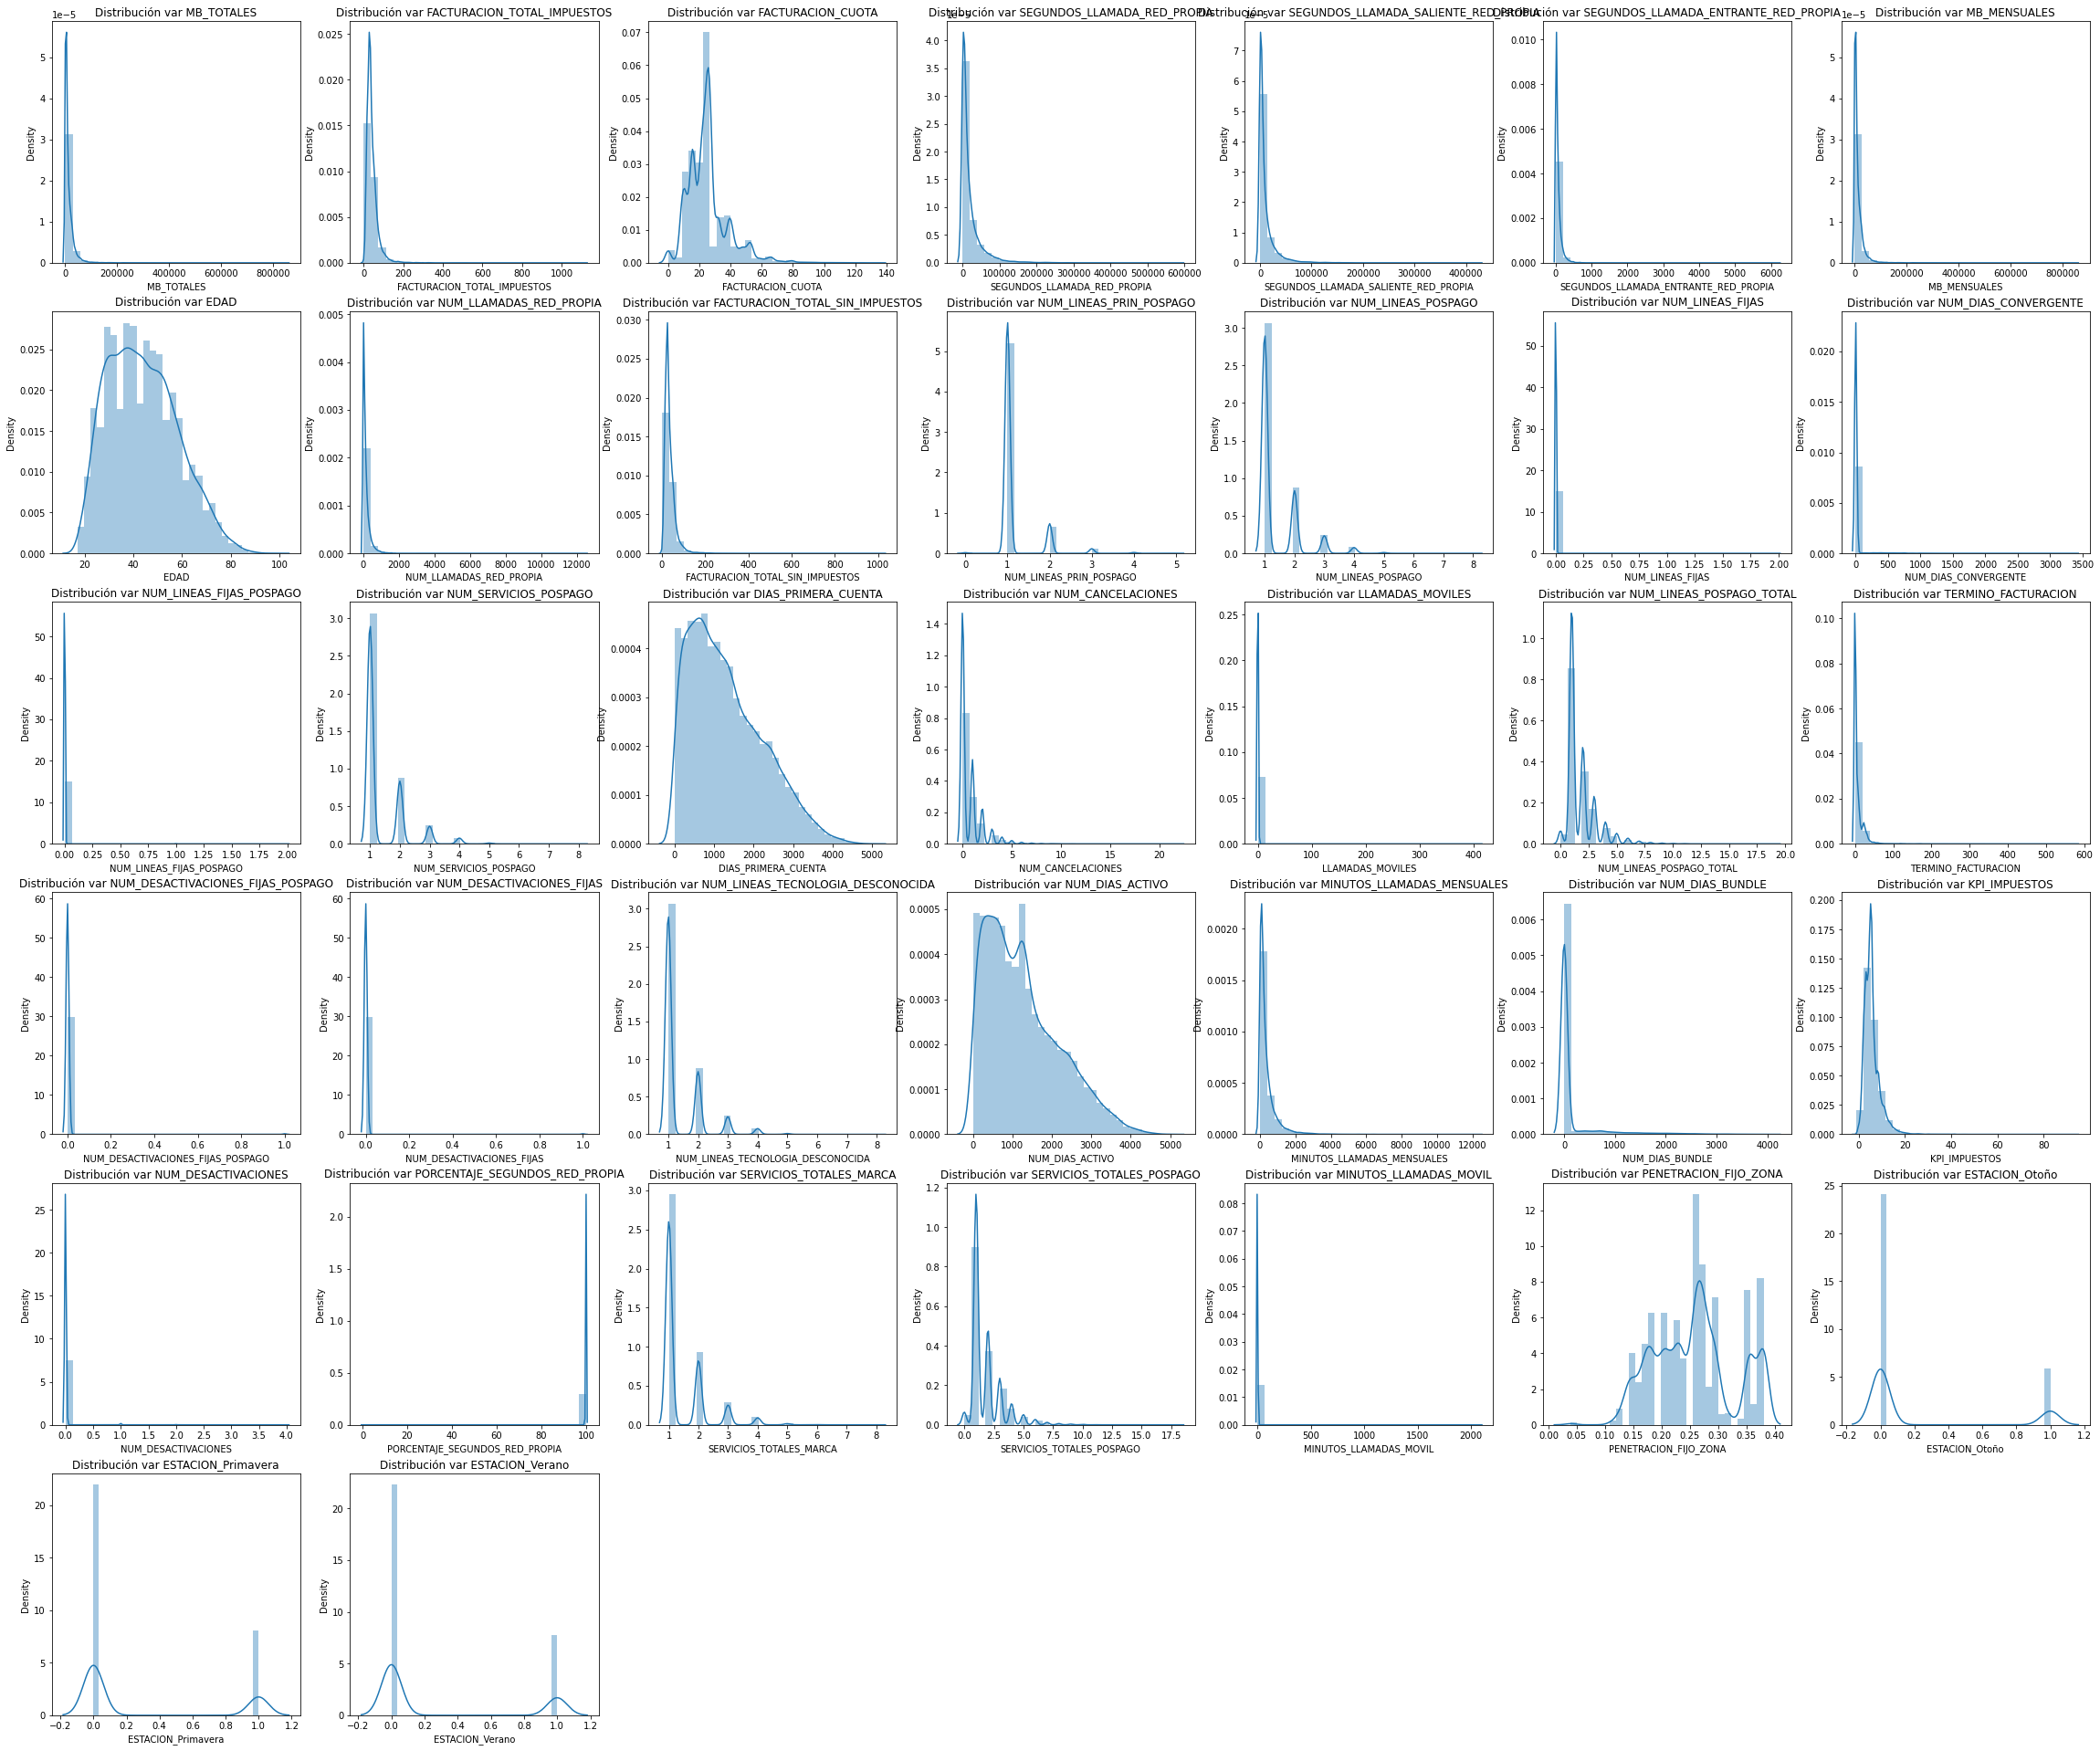

In [ ]:
plt.figure(figsize=(40,40))
n = 0
for i, column in enumerate(X0.columns):
    n+=1
    plt.subplot(7, 7, n)
    sns.distplot(X0[column], bins=30)
    plt.title('Distribución var {}'.format(column))
plt.show()

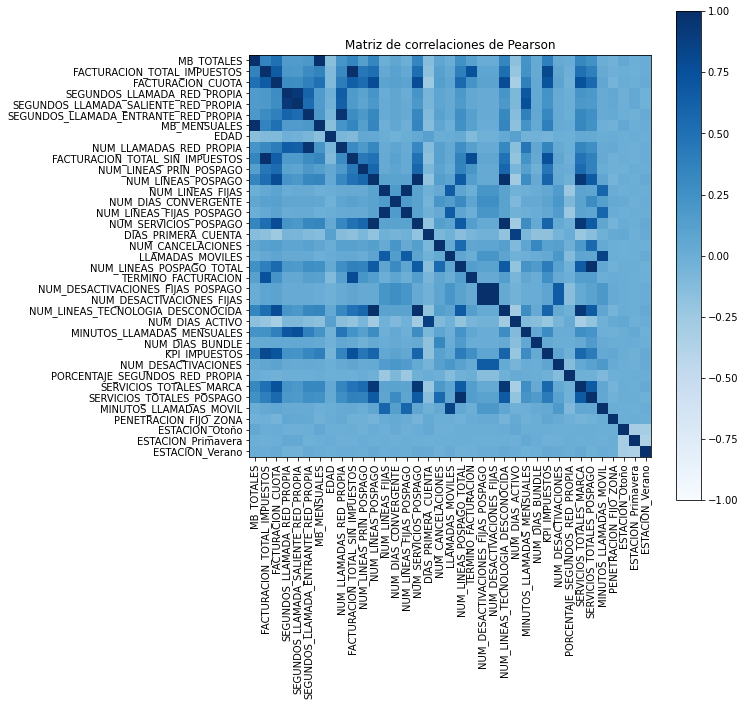

In [ ]:
matriz_correlaciones = X0.corr(method='pearson')
n_ticks = len(X0.columns)
plt.figure( figsize=(9, 9) )
plt.xticks(range(n_ticks), X0.columns, rotation='vertical')
plt.yticks(range(n_ticks), X0.columns)
plt.colorbar(plt.imshow(matriz_correlaciones, interpolation='nearest',
                            vmin=-1., vmax=1.,
                            cmap=plt.get_cmap('Blues')))
_ = plt.title('Matriz de correlaciones de Pearson')

In [ ]:
X0.corr()

,MB_TOTALES,FACTURACION_TOTAL_IMPUESTOS,FACTURACION_CUOTA,SEGUNDOS_LLAMADA_RED_PROPIA,SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,MB_MENSUALES,EDAD,NUM_LLAMADAS_RED_PROPIA,FACTURACION_TOTAL_SIN_IMPUESTOS,...,KPI_IMPUESTOS,NUM_DESACTIVACIONES,PORCENTAJE_SEGUNDOS_RED_PROPIA,SERVICIOS_TOTALES_MARCA,SERVICIOS_TOTALES_POSPAGO,MINUTOS_LLAMADAS_MOVIL,PENETRACION_FIJO_ZONA,ESTACION_Otoño,ESTACION_Primavera,ESTACION_Verano
MB_TOTALES,1.000000,0.357075,0.505986,0.156855,0.161772,0.192585,0.999708,-0.148454,0.212823,0.342523,...,0.386939,0.023707,0.009060,0.322757,0.251616,0.003131,-0.034354,0.050122,-0.005334,0.013464
FACTURACION_TOTAL_IMPUESTOS,0.357075,1.000000,0.662021,0.188252,0.186417,0.295546,0.356112,-0.102922,0.311359,0.996796,...,0.805361,0.069209,-0.015215,0.501331,0.385326,0.031157,-0.009331,0.005488,-0.009386,0.012116
FACTURACION_CUOTA,0.505986,0.662021,1.000000,0.282504,0.278358,0.375619,0.504105,-0.105334,0.399967,0.634713,...,0.719826,0.089040,-0.031669,0.735444,0.550935,0.055253,-0.053295,0.009159,-0.003746,0.020167
SEGUNDOS_LLAMADA_RED_PROPIA,0.156855,0.188252,0.282504,1.000000,0.935915,0.600021,0.156542,-0.013170,0.649955,0.176326,...,0.235525,0.027155,-0.001435,0.214177,0.192468,0.021327,0.050383,-0.015286,0.041485,-0.029399
SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,0.161772,0.186417,0.278358,0.935915,1.000000,0.531526,0.161469,-0.036892,0.625498,0.174895,...,0.231093,0.022528,-0.002679,0.191430,0.174080,0.022460,0.041530,-0.015299,0.039073,-0.026301
SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,0.192585,0.295546,0.375619,0.600021,0.531526,1.000000,0.192032,-0.064774,0.959231,0.282391,...,0.328490,0.023616,-0.001294,0.327404,0.265406,0.021151,0.031507,-0.004023,-0.017340,0.015912
MB_MENSUALES,0.999708,0.356112,0.504105,0.156542,0.161469,0.192032,1.000000,-0.148584,0.212282,0.341593,...,0.385938,0.018638,0.011060,0.321117,0.249919,-0.011212,-0.034229,0.050330,-0.005262,0.013352
EDAD,-0.148454,-0.102922,-0.105334,-0.013170,-0.036892,-0.064774,-0.148584,1.000000,-0.074124,-0.107292,...,-0.048053,-0.007691,-0.010867,0.043526,0.035360,0.004261,0.009628,-0.002855,0.008326,-0.004340
NUM_LLAMADAS_RED_PROPIA,0.212823,0.311359,0.399967,0.649955,0.625498,0.959231,0.212282,-0.074124,1.000000,0.297567,...,0.345576,0.023997,-0.001262,0.337930,0.271556,0.020447,0.029004,-0.006722,-0.011796,0.013924
FACTURACION_TOTAL_SIN_IMPUESTOS,0.342523,0.996796,0.634713,0.176326,0.174895,0.282391,0.341593,-0.107292,0.297567,1.000000,...,0.755366,0.066842,-0.013858,0.477101,0.369987,0.029097,-0.018099,0.005715,-0.008253,0.009979


Variables con fuerte correlacción, eliminamos una delas dos, en nuestro caso eliminamos:

MB_MENSUALES 0.999708

FACTURACION_TOTAL_SIN_IMPUESTOS 0.996796

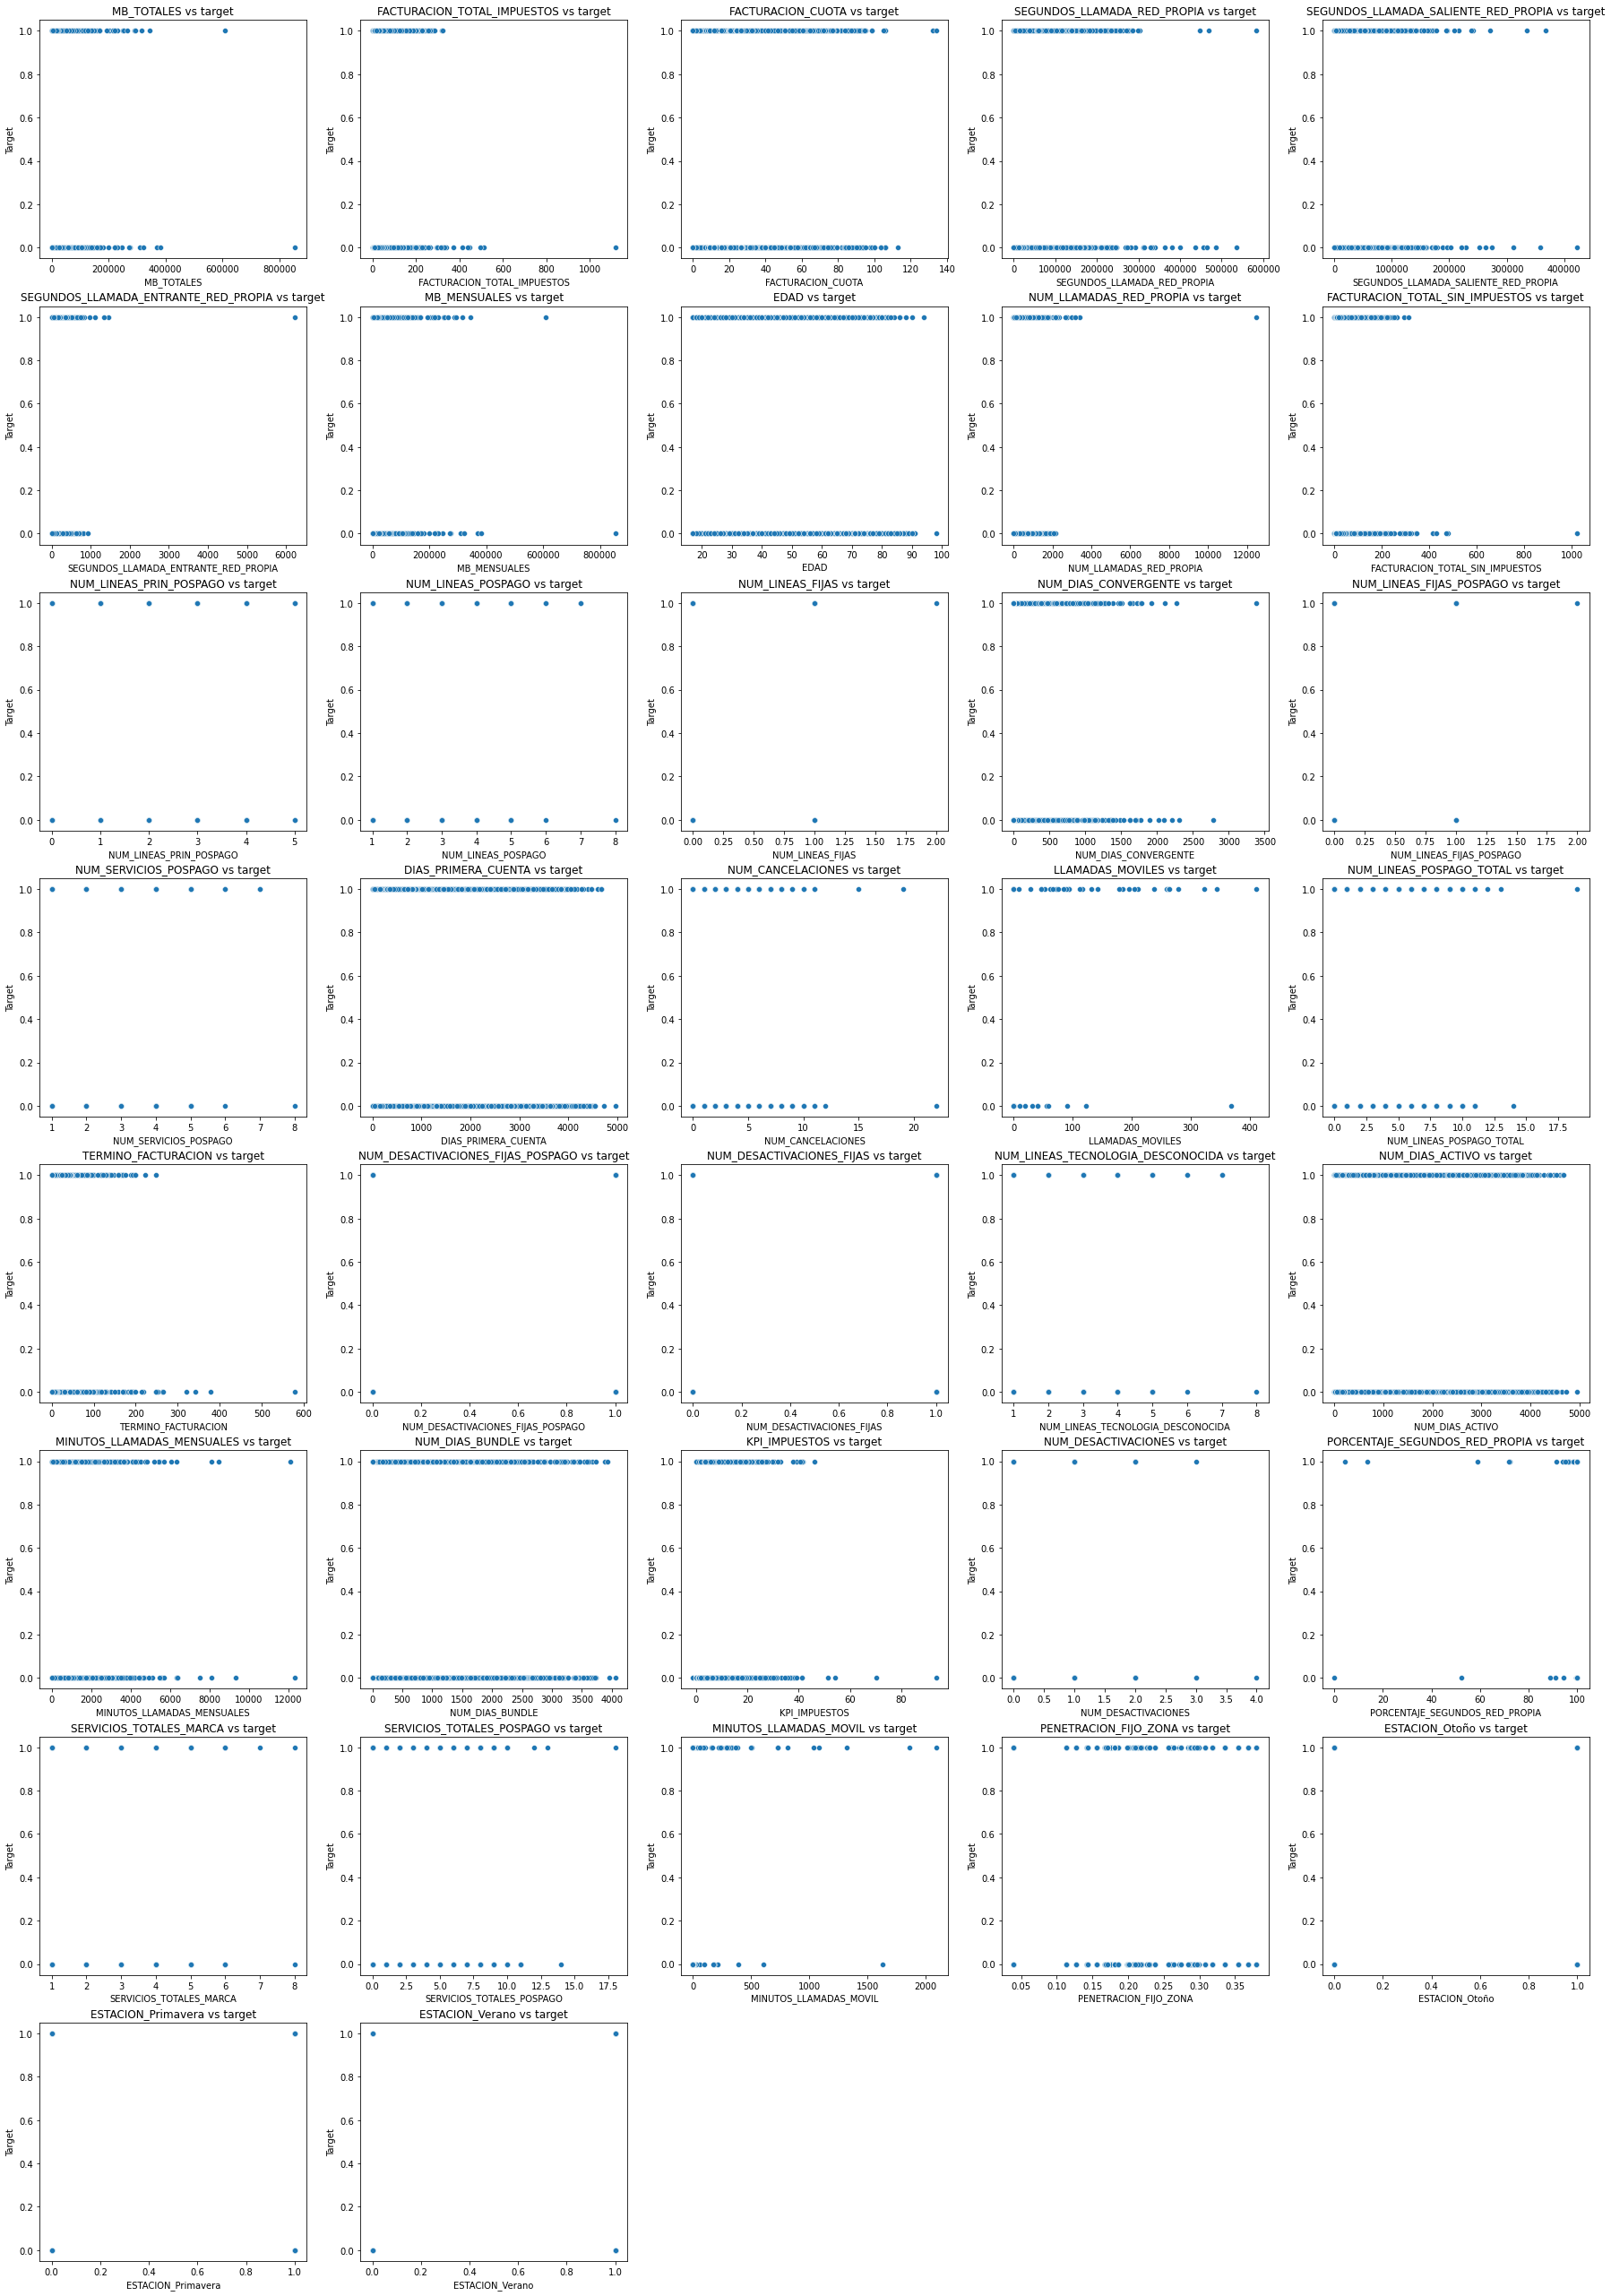

In [ ]:
relaciones_vs_target(X0, Y0)

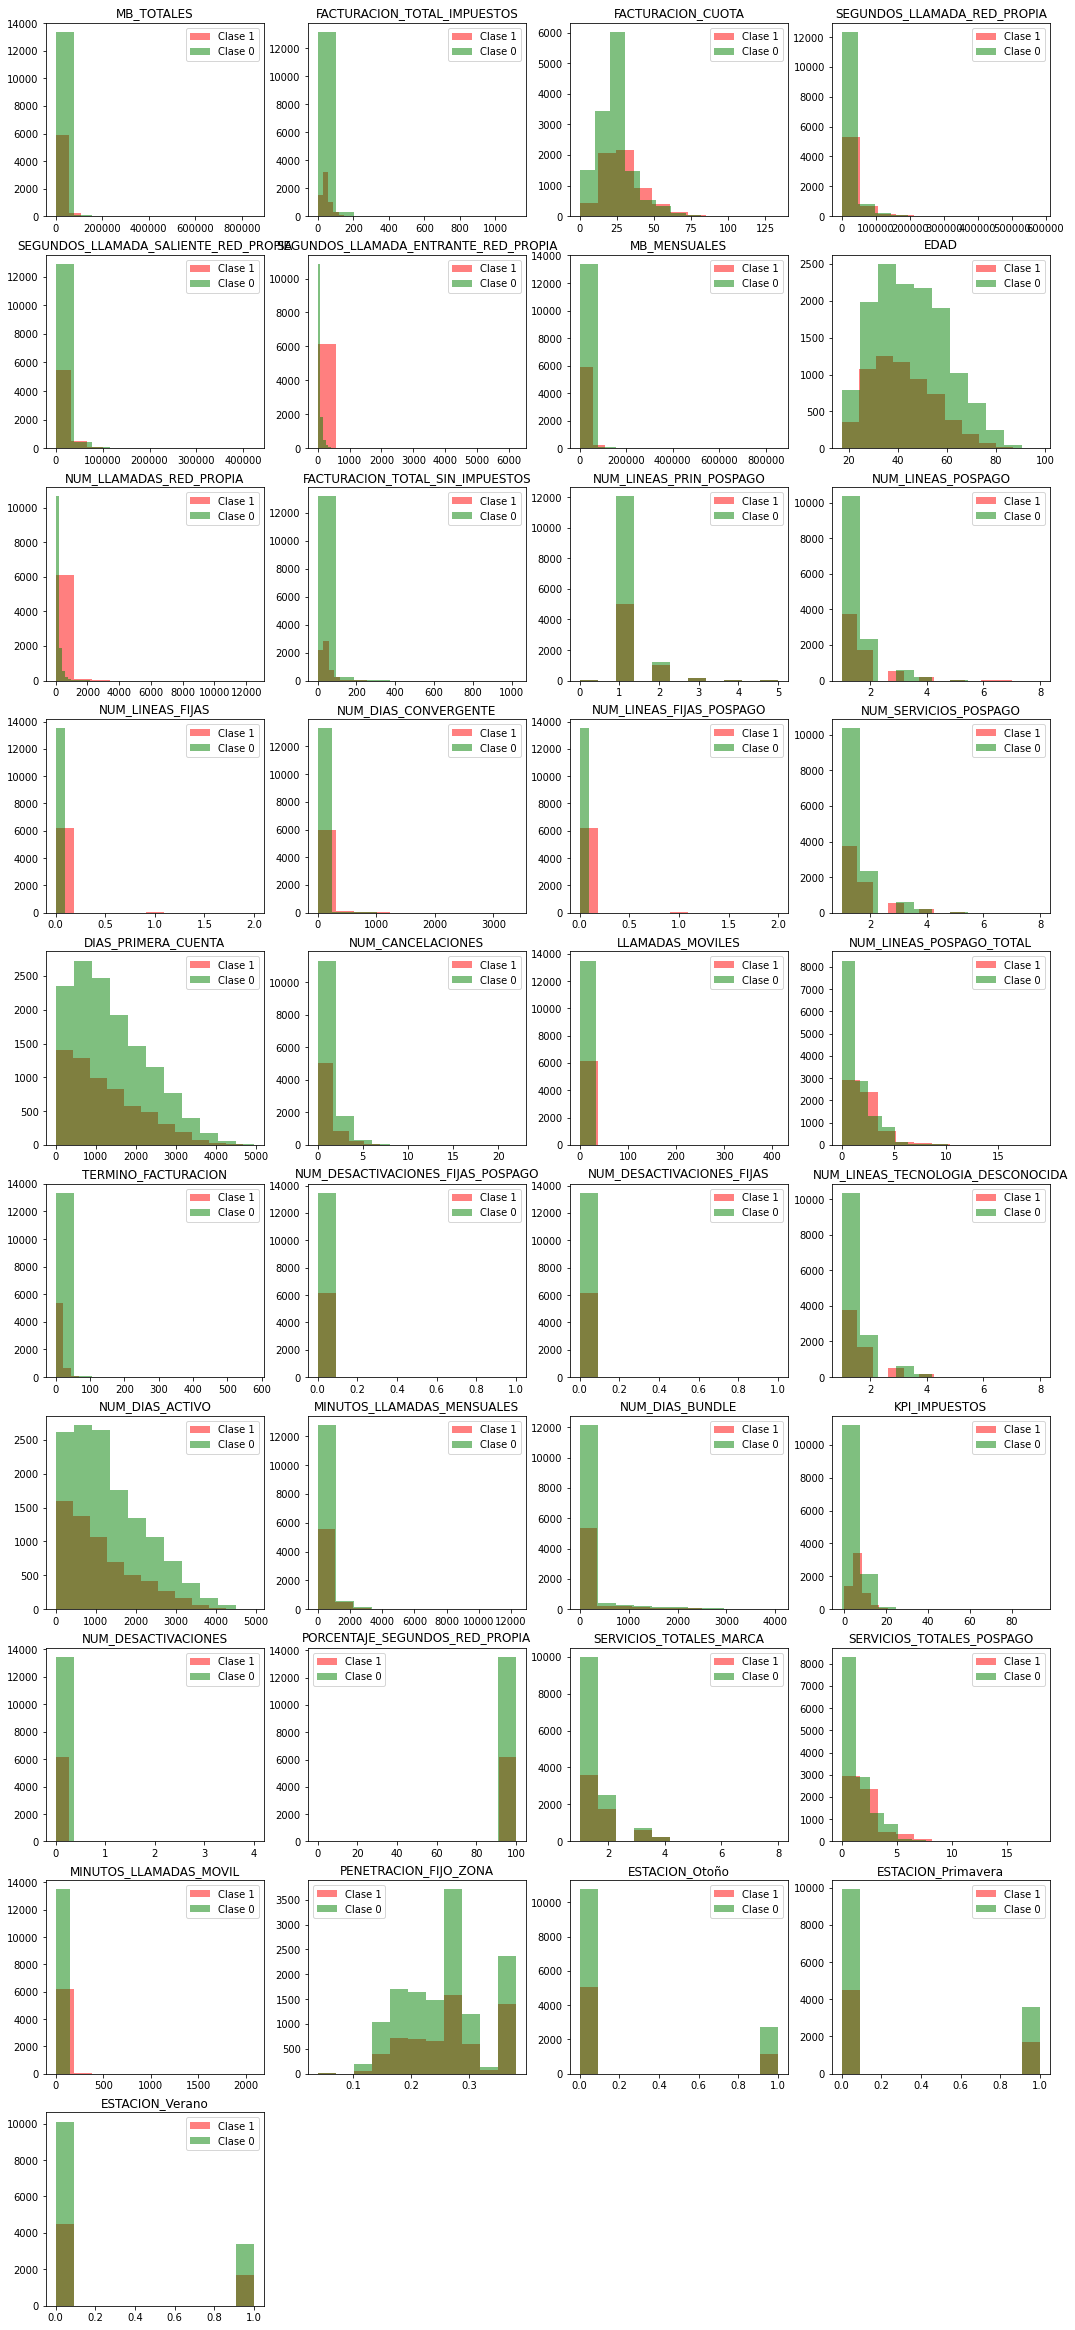

In [ ]:
hist_pos_neg_feat(X0,Y0)

In [ ]:
XY1 = XY0.drop(['MB_MENSUALES','FACTURACION_TOTAL_SIN_IMPUESTOS'],axis=1)

In [ ]:
XY1

,MB_TOTALES,FACTURACION_TOTAL_IMPUESTOS,FACTURACION_CUOTA,SEGUNDOS_LLAMADA_RED_PROPIA,SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,EDAD,NUM_LLAMADAS_RED_PROPIA,NUM_LINEAS_PRIN_POSPAGO,NUM_LINEAS_POSPAGO,...,NUM_DESACTIVACIONES,PORCENTAJE_SEGUNDOS_RED_PROPIA,SERVICIOS_TOTALES_MARCA,SERVICIOS_TOTALES_POSPAGO,MINUTOS_LLAMADAS_MOVIL,PENETRACION_FIJO_ZONA,TARGET,ESTACION_Otoño,ESTACION_Primavera,ESTACION_Verano
0,232.121597,10.186000,0.000000,4523.0,1183.0,28.0,39.0,54.0,1,1,...,0,100.0,2,1,0.0,0.264612,0,0,0,0
1,18280.292969,32.005001,26.450001,13288.0,9194.0,49.0,25.0,152.0,1,1,...,0,100.0,1,2,0.0,0.380171,0,1,0,0
2,2141.692810,37.442001,31.400000,13.0,13.0,0.0,47.0,4.0,2,2,...,0,100.0,2,2,0.0,0.156041,0,0,1,0
3,3181.986496,20.001000,16.530000,0.0,0.0,0.0,43.0,0.0,1,2,...,0,100.0,2,3,0.0,0.228810,1,0,1,0
4,25626.083984,37.005001,26.450001,72783.0,27609.0,151.0,40.0,329.0,1,1,...,0,100.0,1,1,0.0,0.210286,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,20431.367188,21.640001,16.530001,8226.0,4699.0,61.0,39.0,163.0,1,1,...,0,100.0,1,2,0.0,0.180917,1,0,1,0
19996,2717.812500,36.593000,23.969999,22401.0,7645.0,33.0,70.0,87.0,1,1,...,0,100.0,1,1,0.0,0.171539,1,1,0,0
19997,21.569700,9.544000,0.000000,1.0,1.0,0.0,52.0,1.0,1,1,...,0,100.0,1,1,0.0,0.201103,0,0,0,1
19998,16230.392578,32.005001,26.450001,3545.0,2600.0,8.0,40.0,36.0,1,1,...,0,100.0,1,1,0.0,0.274430,1,0,0,1


Transformación de datos para cumplir las hipótesis:

Como posteriormente vamos a aplicar un algoritmo K-means, los datos deben cumplir una serie de hipótesis.

El K-means supone que los datos tienen una distribución normal. Además, es muy propenso a outliers. Por lo tanto, debemos transformar las variables para que sigan una distribución normal y tratar los outliers.

In [ ]:
X1 = XY1.drop('TARGET', axis=1)
Y1 = XY1['TARGET']

In [ ]:
correlaciones_target = matriz_correlaciones.values[ -1, : -1]
indices_inversos =  abs(correlaciones_target[ : ]).argsort()[ : : -1]
diccionario = {}
for nombre, correlacion in zip( XY1.columns[indices_inversos], list(correlaciones_target[indices_inversos] ) ):
    diccionario[nombre] = correlacion
pd.DataFrame.from_dict(diccionario, orient='index', columns=['Correlación con la target'])

,Correlación con la target
ESTACION_Verano,-0.356762
ESTACION_Primavera,-0.291671
SEGUNDOS_LLAMADA_RED_PROPIA,-0.029399
SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,-0.026301
PORCENTAJE_SEGUNDOS_RED_PROPIA,0.025306
NUM_DIAS_CONVERGENTE,0.025120
NUM_CANCELACIONES,0.025120
MINUTOS_LLAMADAS_MENSUALES,0.025120
MINUTOS_LLAMADAS_MOVIL,0.024516
SERVICIOS_TOTALES_MARCA,0.020533


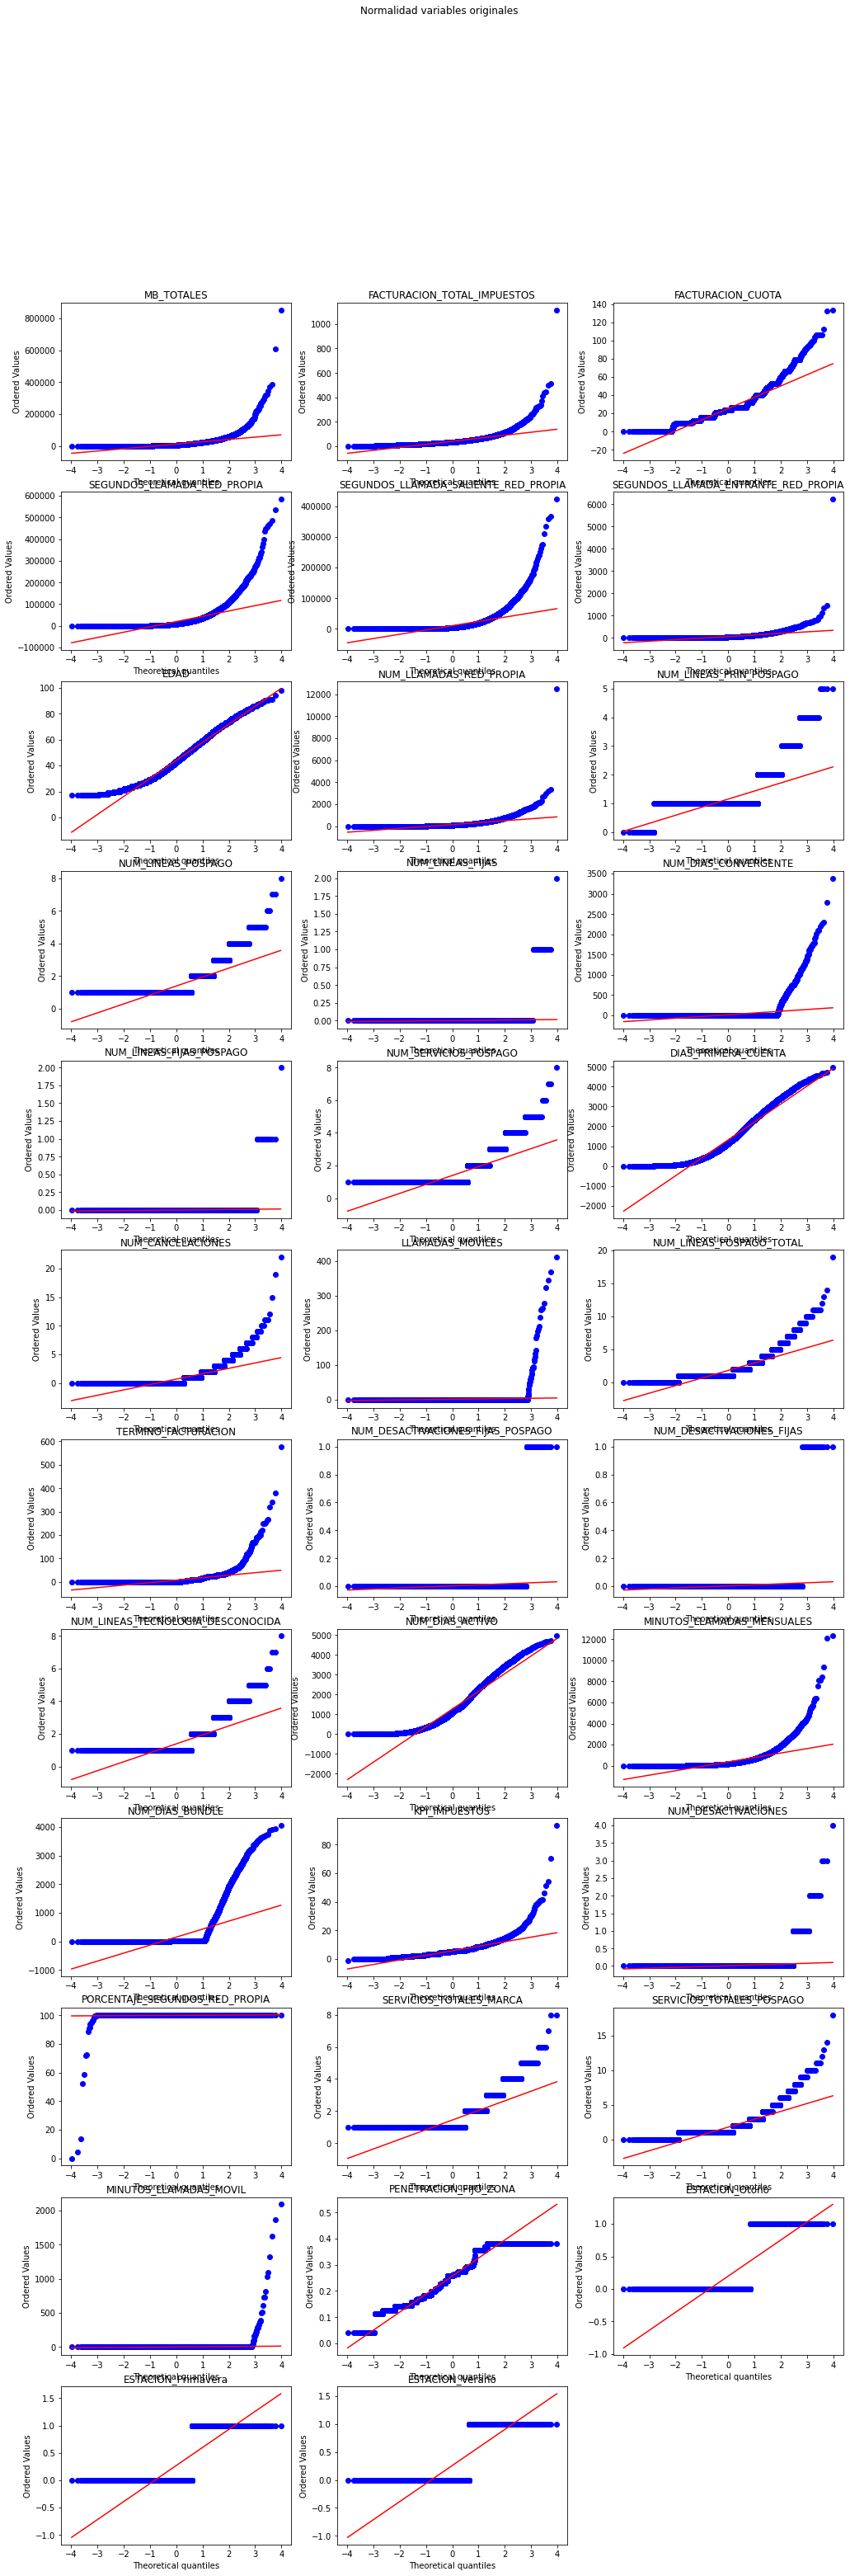

In [ ]:
shapiro_test = comprueba_normalidad(X1, title='Normalidad variables originales')

In [ ]:
shapiro_test

,Test Statistic,p-value
MB_TOTALES,0.522559,0.0
FACTURACION_TOTAL_IMPUESTOS,0.717978,0.0
FACTURACION_CUOTA,0.900223,0.0
SEGUNDOS_LLAMADA_RED_PROPIA,0.592998,0.0
SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,0.538341,0.0
SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,0.558240,0.0
EDAD,0.978021,0.0
NUM_LLAMADAS_RED_PROPIA,0.587338,0.0
NUM_LINEAS_PRIN_POSPAGO,0.415385,0.0
NUM_LINEAS_POSPAGO,0.597964,0.0


Todas las variables son significativamente estadísticas no distribuidas como una normal.

Test de Shapiro-Wilk: Si el p-value es menor a un nivel de significancia α , se concluye que la distribución no proviene de una normal.

Ahora transformo las variables con una transformación Yeo-Yohnson.

In [ ]:
yj = PowerTransformer(method='yeo-johnson')
X1_yeojohnson = yj.fit_transform(X1)
X1_yeojohnson = pd.DataFrame(X1_yeojohnson, columns=X1.columns)

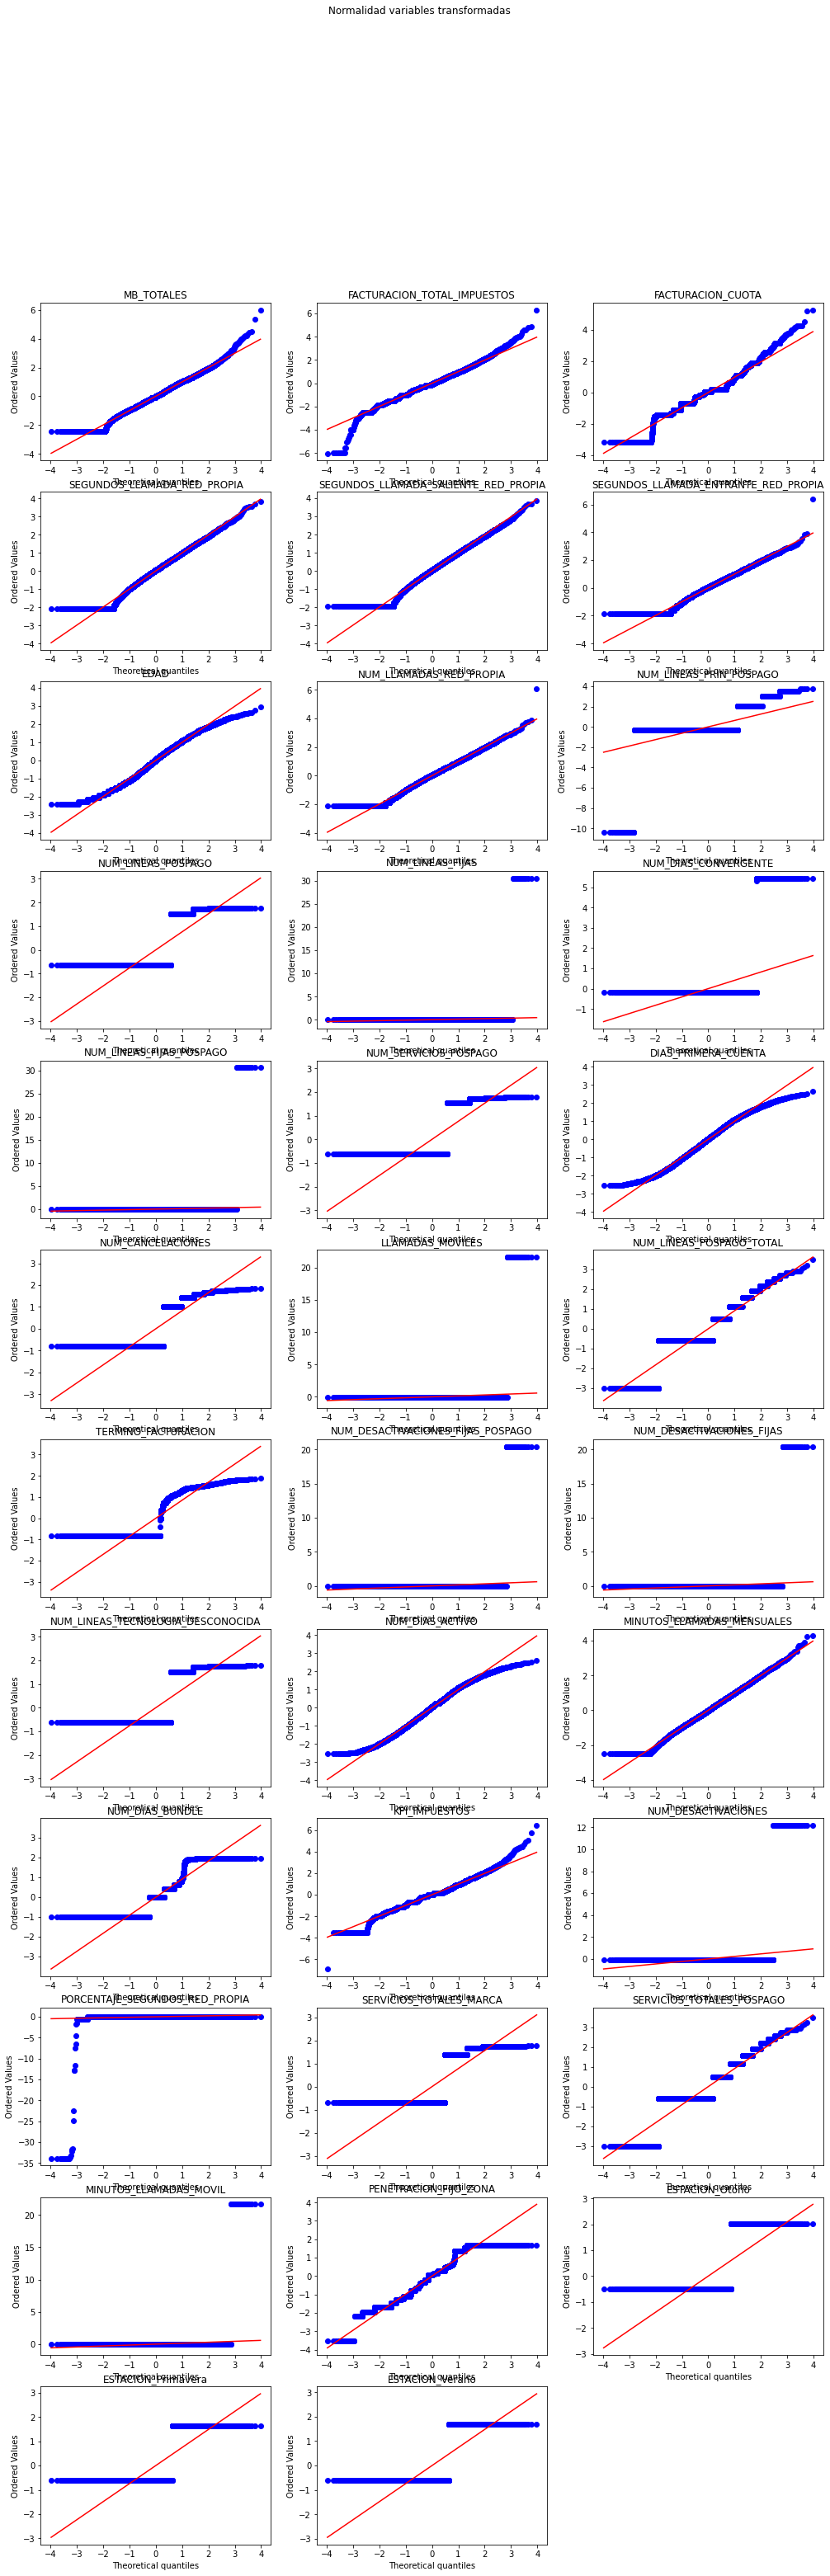

In [ ]:
shapiro_test = comprueba_normalidad(X1_yeojohnson, title='Normalidad variables transformadas')

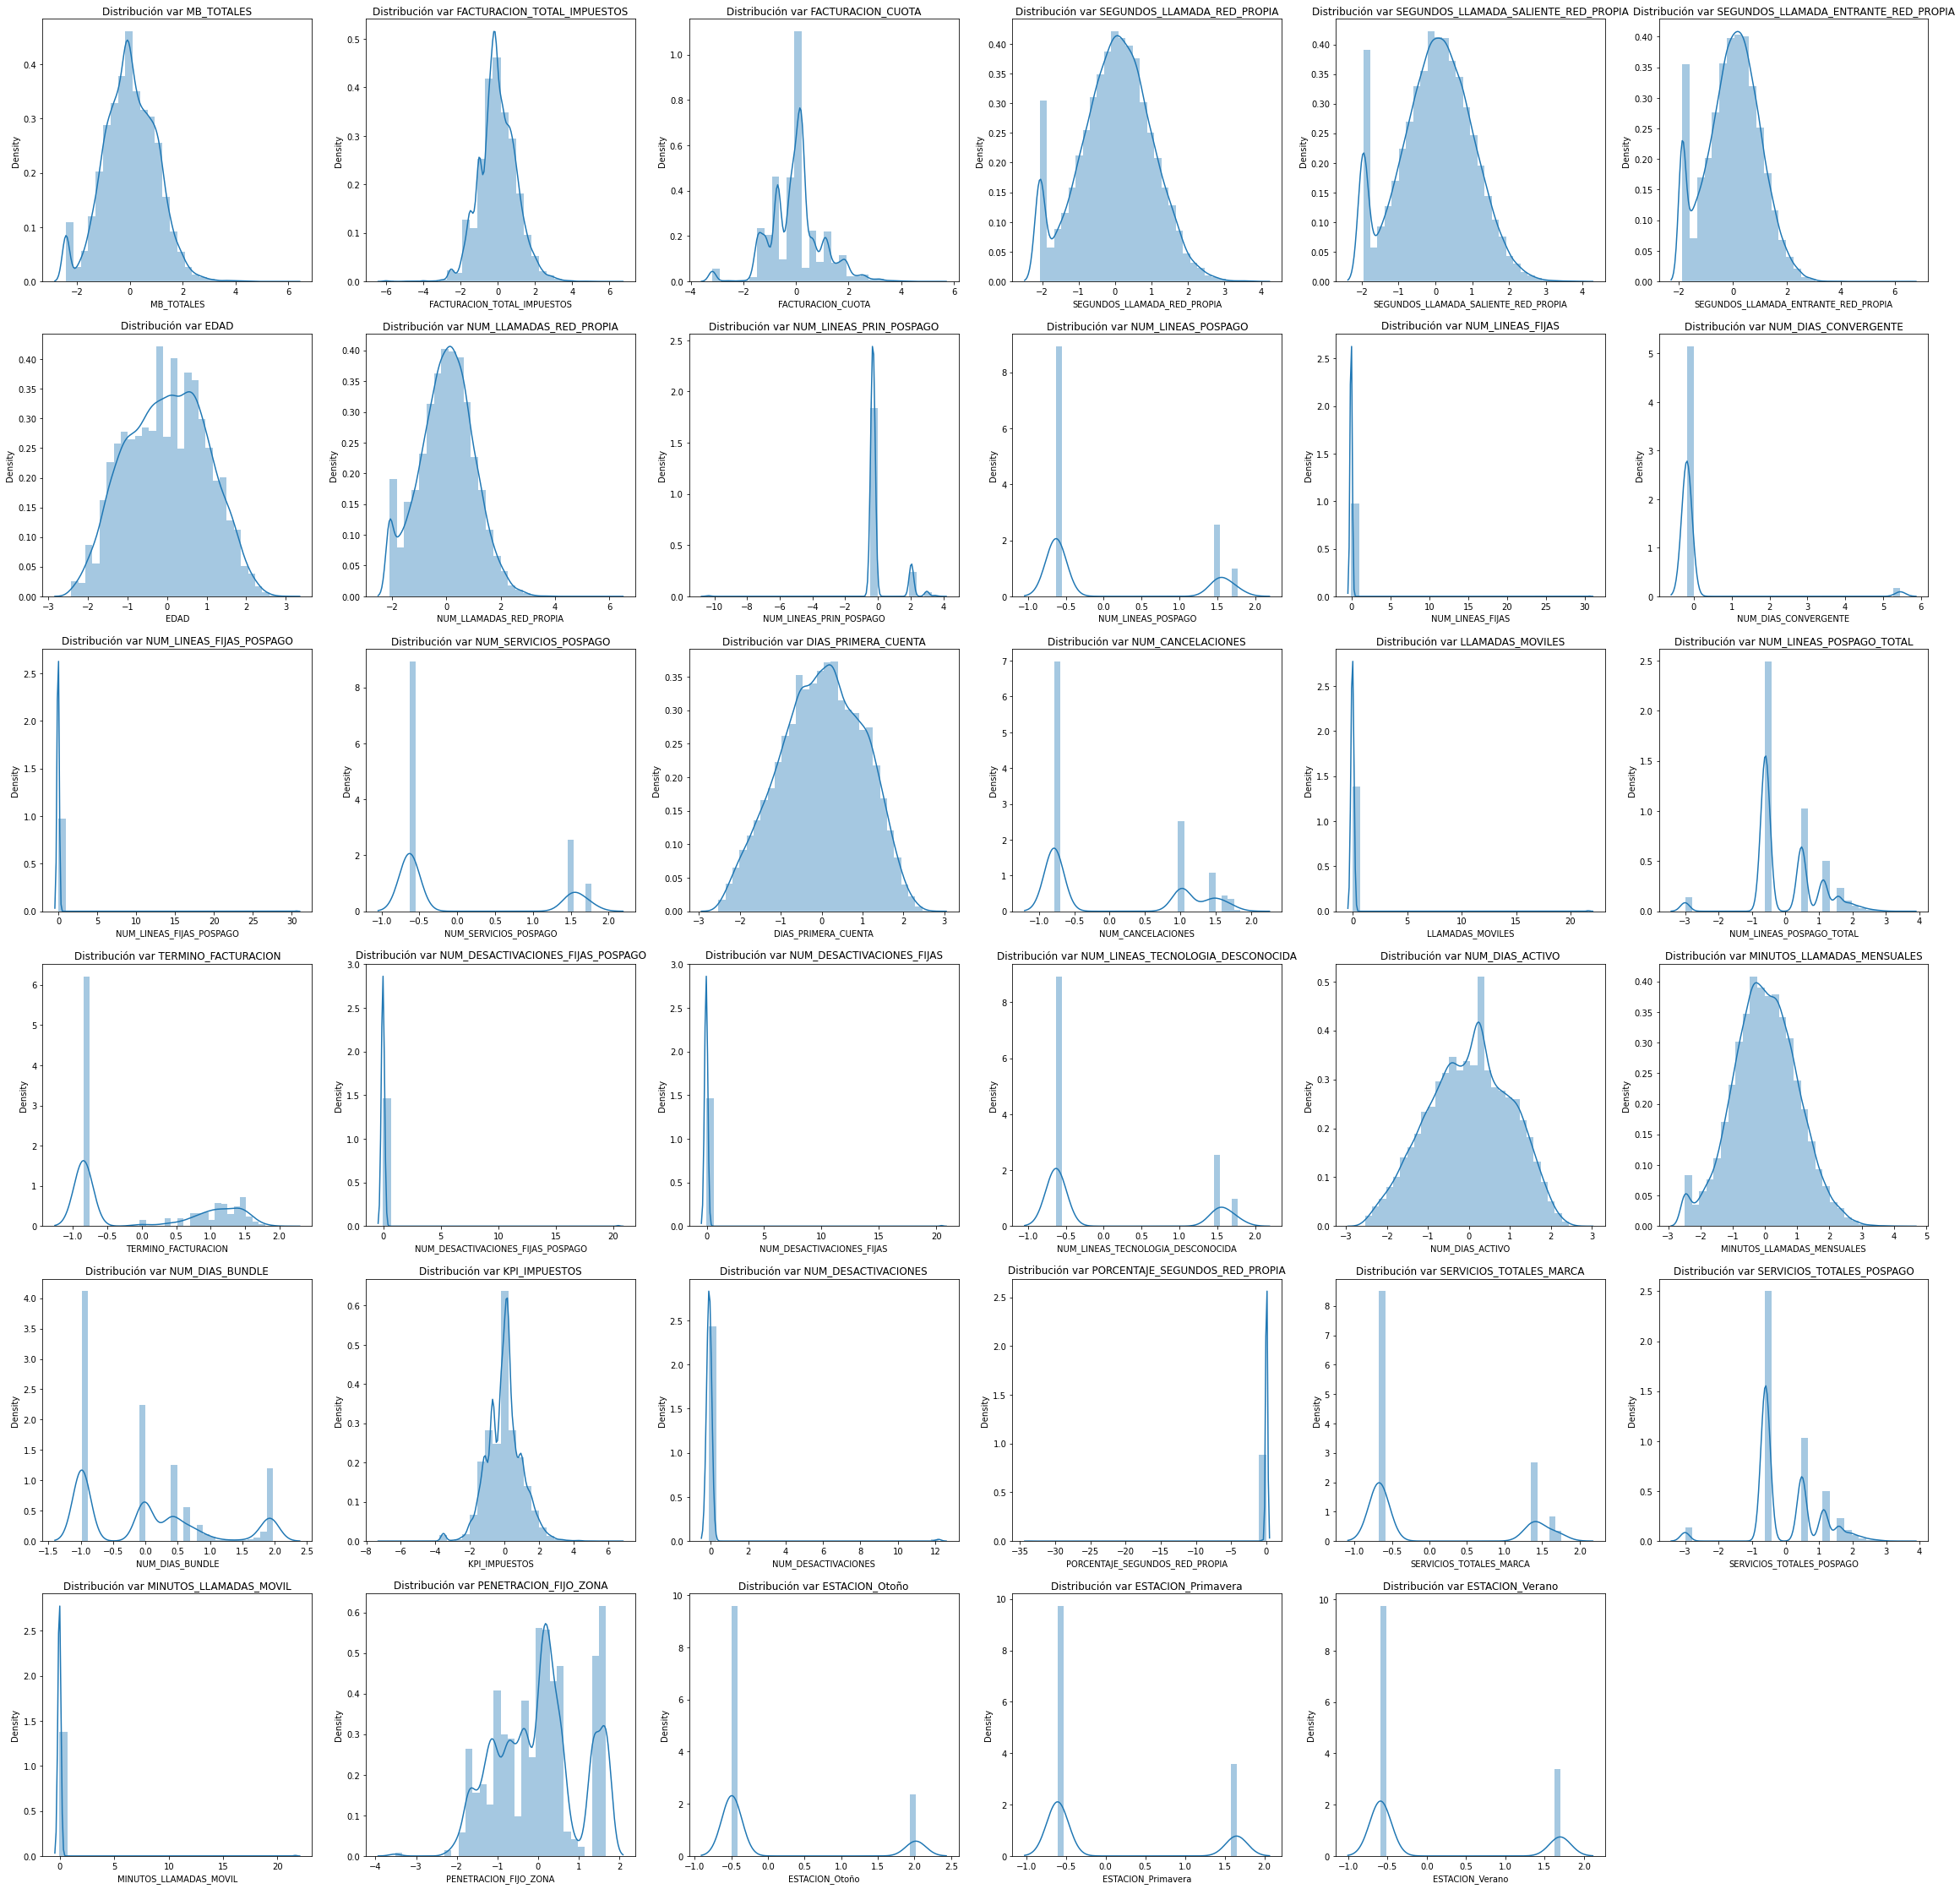

In [ ]:
plt.figure(figsize=(40,40))
n = 0
for i, column in enumerate(X1_yeojohnson.columns):
    n+=1
    plt.subplot(6, 6, n)
    sns.distplot(X1_yeojohnson[column], bins=30)
    plt.title('Distribución var {}'.format(column))
plt.show()

##Tratamiento de outliers:

In [ ]:
# Ajusto el modelo LOF para detectar outliers
clf = LocalOutlierFactor(n_neighbors=55, contamination='auto')
# Las predicciones del modelo son 1 si es un valor típico
# o un -1 si es un valor atípico u outlier
y_pred = clf.fit_predict(XY1)
n_outliers = sum(y_pred==-1)
n_total = len(y_pred)
XY1_scores = clf.negative_outlier_factor_
radius = (XY1_scores.max() - XY1_scores) / (XY1_scores.max() - XY1_scores.min())
print(u'El número de outliers detectados es de {} de un total de {}'.format(n_outliers, n_total))

El número de outliers detectados es de 402 de un total de 19689


#CLUSTENING EN DOS GRUPOS

#SEGMENTACIÓN EN DOS GRUPOS (USAMOS K-MEANS)

Como ya hemos realizado todos los pasos de pretratamiento de datos ya podemos aplicar directamente el modeo de clustening, en este caso, K-means.Además ya tenemos el número de clúster que queremos, ya que nos dicen que separemos en dos grupos.

Pese a saber el número de grupos, aplicamos la regla del codo para ver cuál sería el número optimo de clúster.

Escalado previo de los datos:

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
X1_escalado = scaler.fit_transform(XY1)
X1_escalado = pd.DataFrame(X1_escalado,columns=XY1.columns)
X1_escalado.head()

,MB_TOTALES,FACTURACION_TOTAL_IMPUESTOS,FACTURACION_CUOTA,SEGUNDOS_LLAMADA_RED_PROPIA,SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,EDAD,NUM_LLAMADAS_RED_PROPIA,NUM_LINEAS_PRIN_POSPAGO,NUM_LINEAS_POSPAGO,...,NUM_DESACTIVACIONES,PORCENTAJE_SEGUNDOS_RED_PROPIA,SERVICIOS_TOTALES_MARCA,SERVICIOS_TOTALES_POSPAGO,MINUTOS_LLAMADAS_MOVIL,PENETRACION_FIJO_ZONA,TARGET,ESTACION_Otoño,ESTACION_Primavera,ESTACION_Verano
0,0.000272,0.009124,0.000000,0.007742,0.002799,0.004502,0.271605,0.004321,0.2,0.000000,...,0.0,1.0,0.142857,0.055556,0.0,0.660729,0.0,0.0,0.0,0.0
1,0.021415,0.028664,0.197550,0.022744,0.021749,0.007878,0.098765,0.012163,0.2,0.000000,...,0.0,1.0,0.000000,0.111111,0.0,1.000000,0.0,1.0,0.0,0.0
2,0.002509,0.033533,0.234521,0.000022,0.000031,0.000000,0.370370,0.000320,0.4,0.142857,...,0.0,1.0,0.142857,0.111111,0.0,0.341975,0.0,0.0,1.0,0.0
3,0.003728,0.017914,0.123460,0.000000,0.000000,0.000000,0.320988,0.000000,0.2,0.142857,...,0.0,1.0,0.142857,0.166667,0.0,0.555618,1.0,0.0,1.0,0.0
4,0.030021,0.033141,0.197550,0.124577,0.065312,0.024277,0.283951,0.026326,0.2,0.000000,...,0.0,1.0,0.000000,0.055556,0.0,0.501232,1.0,0.0,0.0,0.0


In [ ]:
Xsolo_escalado = X1_escalado.drop('TARGET', axis=1)
Ysolo = X1_escalado['TARGET']

In [ ]:
Xsolo_escalado

,MB_TOTALES,FACTURACION_TOTAL_IMPUESTOS,FACTURACION_CUOTA,SEGUNDOS_LLAMADA_RED_PROPIA,SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,EDAD,NUM_LLAMADAS_RED_PROPIA,NUM_LINEAS_PRIN_POSPAGO,NUM_LINEAS_POSPAGO,...,KPI_IMPUESTOS,NUM_DESACTIVACIONES,PORCENTAJE_SEGUNDOS_RED_PROPIA,SERVICIOS_TOTALES_MARCA,SERVICIOS_TOTALES_POSPAGO,MINUTOS_LLAMADAS_MOVIL,PENETRACION_FIJO_ZONA,ESTACION_Otoño,ESTACION_Primavera,ESTACION_Verano
0,0.000272,0.009124,0.000000,0.007742,0.002799,0.004502,0.271605,0.004321,0.2,0.000000,...,0.031242,0.0,1.0,0.142857,0.055556,0.0,0.660729,0.0,0.0,0.0
1,0.021415,0.028664,0.197550,0.022744,0.021749,0.007878,0.098765,0.012163,0.2,0.000000,...,0.071245,0.0,1.0,0.000000,0.111111,0.0,1.000000,1.0,0.0,0.0
2,0.002509,0.033533,0.234521,0.000022,0.000031,0.000000,0.370370,0.000320,0.4,0.142857,...,0.034138,0.0,1.0,0.142857,0.111111,0.0,0.341975,0.0,1.0,0.0
3,0.003728,0.017914,0.123460,0.000000,0.000000,0.000000,0.320988,0.000000,0.2,0.142857,...,0.049232,0.0,1.0,0.142857,0.166667,0.0,0.555618,0.0,1.0,0.0
4,0.030021,0.033141,0.197550,0.124577,0.065312,0.024277,0.283951,0.026326,0.2,0.000000,...,0.071245,0.0,1.0,0.000000,0.055556,0.0,0.501232,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19684,0.023935,0.019381,0.123460,0.014080,0.011116,0.009807,0.271605,0.013043,0.2,0.000000,...,0.052243,0.0,1.0,0.000000,0.111111,0.0,0.415007,0.0,1.0,0.0
19685,0.003184,0.032772,0.179028,0.038342,0.018085,0.005305,0.654321,0.006962,0.2,0.000000,...,0.079653,0.0,1.0,0.000000,0.055556,0.0,0.387475,1.0,0.0,0.0
19686,0.000025,0.008549,0.000000,0.000002,0.000002,0.000000,0.432099,0.000080,0.2,0.000000,...,0.030062,0.0,1.0,0.000000,0.055556,0.0,0.474273,0.0,0.0,1.0
19687,0.019014,0.028664,0.197550,0.006068,0.006151,0.001286,0.283951,0.002881,0.2,0.000000,...,0.071245,0.0,1.0,0.000000,0.055556,0.0,0.689554,0.0,0.0,1.0


In [ ]:
cluster_range = range(1,10)
cluster_wss=[]
for cluster in cluster_range:
    model = KMeans(cluster)
    model.fit(Xsolo_escalado)
    cluster_wss.append(model.inertia_)

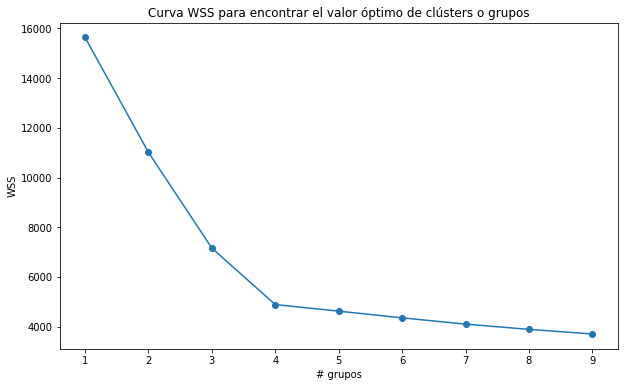

In [ ]:
plt.figure(figsize=[10,6])
plt.title('Curva WSS para encontrar el valor óptimo de clústers o grupos')
plt.xlabel('# grupos')
plt.ylabel('WSS')
plt.plot(list(cluster_range),cluster_wss,marker='o')
plt.show()

Vemos según la regla del codo que el ideal serían 4 grupos, k=4. En el enunciado nos piden segmentación en dos, k=2

In [ ]:
model = KMeans(n_clusters=2,random_state=0)
model.fit(Xsolo_escalado)

KMeans(n_clusters=2, random_state=0)

Ahora con este modelo predecimos y obtemos los grupos con K=2. Se crea un dataframe con todas las variables y una nueva que sea la predicción del clúster asignado:

In [ ]:
# Dataframe con variables originales y la predicción
df_total = X1.copy()
df_total['cluster']=model.predict(Xsolo_escalado)
df_total[:2]

,MB_TOTALES,FACTURACION_TOTAL_IMPUESTOS,FACTURACION_CUOTA,SEGUNDOS_LLAMADA_RED_PROPIA,SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,EDAD,NUM_LLAMADAS_RED_PROPIA,NUM_LINEAS_PRIN_POSPAGO,NUM_LINEAS_POSPAGO,...,NUM_DESACTIVACIONES,PORCENTAJE_SEGUNDOS_RED_PROPIA,SERVICIOS_TOTALES_MARCA,SERVICIOS_TOTALES_POSPAGO,MINUTOS_LLAMADAS_MOVIL,PENETRACION_FIJO_ZONA,ESTACION_Otoño,ESTACION_Primavera,ESTACION_Verano,cluster
0,232.121597,10.186000,0.000000,4523.0,1183.0,28.0,39.0,54.0,1,1,...,0,100.0,2,1,0.0,0.264612,0,0,0,0
1,18280.292969,32.005001,26.450001,13288.0,9194.0,49.0,25.0,152.0,1,1,...,0,100.0,1,2,0.0,0.380171,1,0,0,0


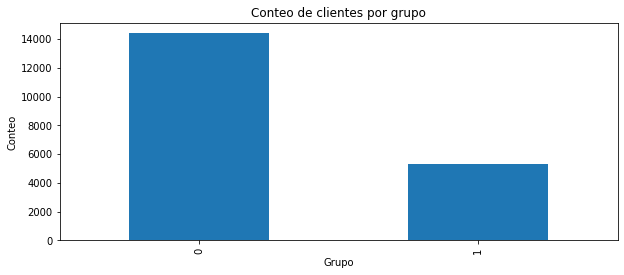

In [ ]:
df_total.cluster.value_counts().plot(kind='bar', figsize=(10,4))
plt.title('Conteo de clientes por grupo')
plt.xlabel('Grupo')
_ = plt.ylabel('Conteo')

In [ ]:
# Dataframe con las medias de las variables en cada uno de los grupos
descriptivos_grupos = df_total.groupby(['cluster'],as_index=False).mean()
descriptivos_grupos

,cluster,MB_TOTALES,FACTURACION_TOTAL_IMPUESTOS,FACTURACION_CUOTA,SEGUNDOS_LLAMADA_RED_PROPIA,SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,EDAD,NUM_LLAMADAS_RED_PROPIA,NUM_LINEAS_PRIN_POSPAGO,...,KPI_IMPUESTOS,NUM_DESACTIVACIONES,PORCENTAJE_SEGUNDOS_RED_PROPIA,SERVICIOS_TOTALES_MARCA,SERVICIOS_TOTALES_POSPAGO,MINUTOS_LLAMADAS_MOVIL,PENETRACION_FIJO_ZONA,ESTACION_Otoño,ESTACION_Primavera,ESTACION_Verano
0,0,12380.890342,41.265982,25.338650,18629.435178,9963.834664,64.403930,43.865685,159.124991,1.150823,...,5.722029,0.008888,99.973586,1.438997,1.79307,1.069774,0.256799,0.269426,0.0,0.35192
1,1,12139.416198,40.649268,25.228327,21610.783283,11640.942700,60.736952,44.130010,153.044818,1.160552,...,5.595881,0.005484,99.979123,1.437973,1.81146,0.525627,0.257063,0.000000,1.0,0.00000


##Obtenemos una representación de los grupos con PCA:

In [ ]:
pca2 = PCA(n_components=2)
pc = pca2.fit_transform(Xsolo_escalado)
pc_df = pd.DataFrame(pc)
pca = pd.concat([pc_df, df_total['cluster']],axis=1)
pca.columns = ['pc1','pc2','cluster']
pca[:2]

,pc1,pc2,cluster
0,-0.010305,0.068712,0.0
1,-0.056705,0.851438,0.0


In [ ]:
pca2 = PCA(n_components=3)
pc = pca2.fit_transform(Xsolo_escalado)
pc_df = pd.DataFrame(pc)
pca = pd.concat([pc_df, df_total['cluster']],axis=1)
pca.columns = ['pc1','pc2','pc3','cluster']
pca[:2]

,pc1,pc2,pc3,cluster
0,-0.010305,0.068712,0.248896,0.0
1,-0.056705,0.851438,0.132073,0.0


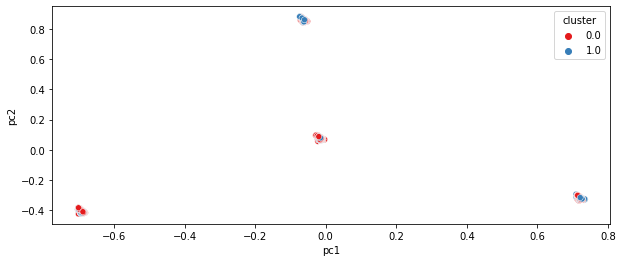

In [ ]:
plt.figure(figsize=[10,4])
sns.scatterplot(x='pc1', y='pc2', hue= 'cluster', data=pca, palette='Set1')
plt.show()

Vemos con la reducción de dimensiones que si sería buenos los 4 grupos que predice regla del codo

In [ ]:
df_total.groupby(by='cluster').count()

,MB_TOTALES,FACTURACION_TOTAL_IMPUESTOS,FACTURACION_CUOTA,SEGUNDOS_LLAMADA_RED_PROPIA,SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,EDAD,NUM_LLAMADAS_RED_PROPIA,NUM_LINEAS_PRIN_POSPAGO,NUM_LINEAS_POSPAGO,...,KPI_IMPUESTOS,NUM_DESACTIVACIONES,PORCENTAJE_SEGUNDOS_RED_PROPIA,SERVICIOS_TOTALES_MARCA,SERVICIOS_TOTALES_POSPAGO,MINUTOS_LLAMADAS_MOVIL,PENETRACION_FIJO_ZONA,ESTACION_Otoño,ESTACION_Primavera,ESTACION_Verano
cluster,,,,,,,,,,,,,,,,,,,,,
0,14401,14401,14401,14401,14401,14401,14401,14401,14401,14401,...,14401,14401,14401,14401,14401,14401,14401,14401,14401,14401
1,5288,5288,5288,5288,5288,5288,5288,5288,5288,5288,...,5288,5288,5288,5288,5288,5288,5288,5288,5288,5288


Text(0.5, 0, 'Número de clúster')

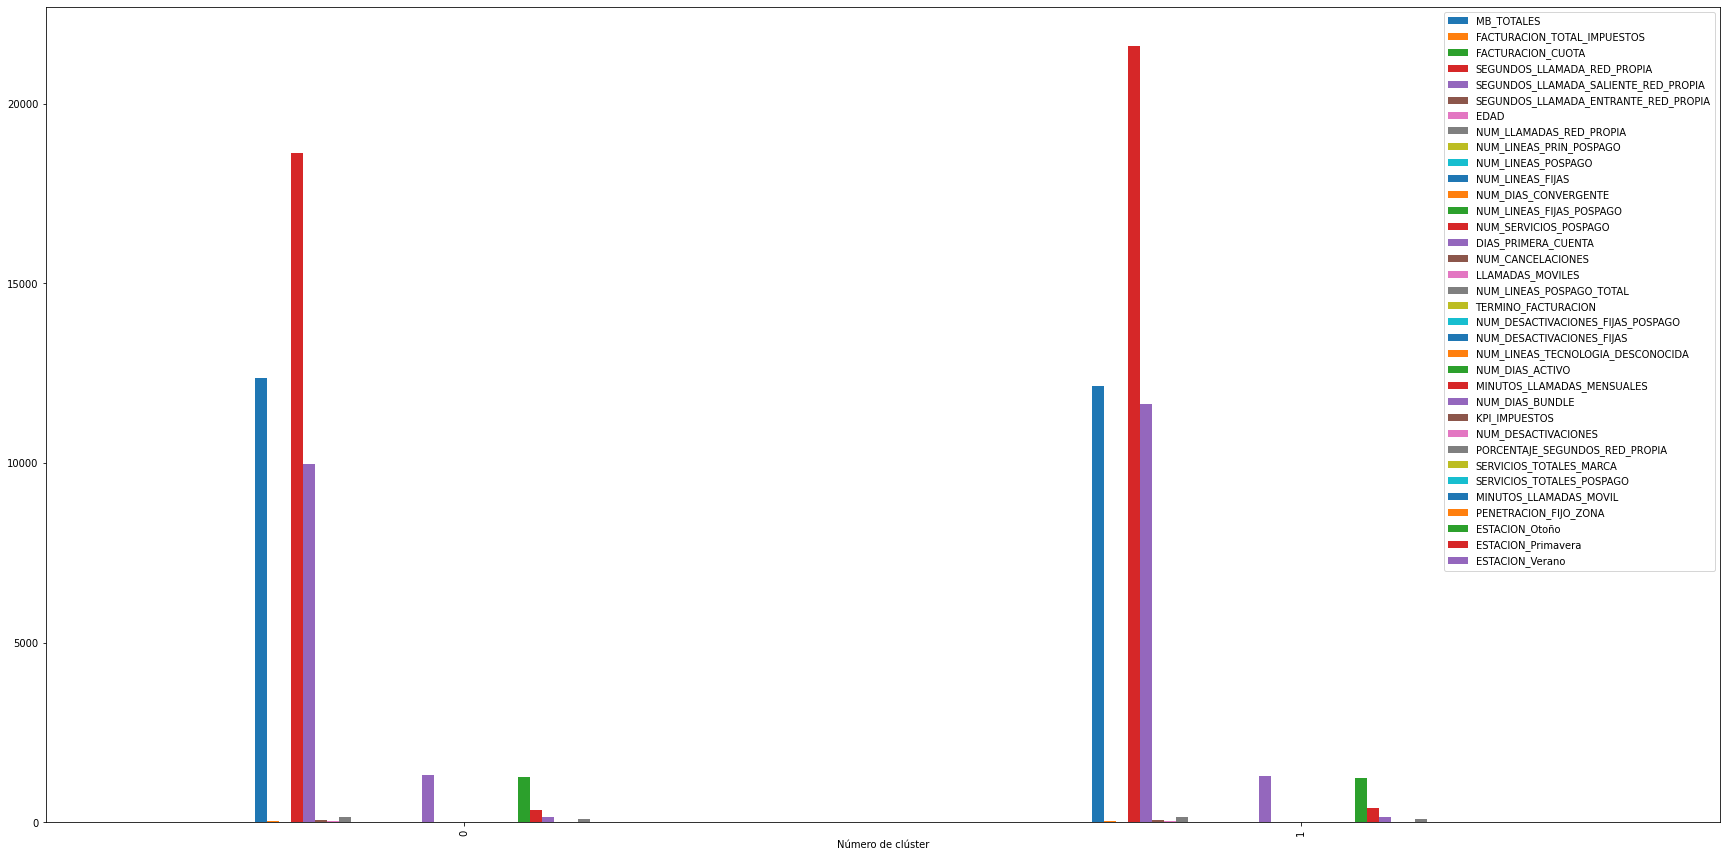

In [ ]:
df_total.groupby('cluster').mean().plot(kind='bar', figsize=(30,15))
plt.xlabel(u'Número de clúster')

In [ ]:
df_total

,MB_TOTALES,FACTURACION_TOTAL_IMPUESTOS,FACTURACION_CUOTA,SEGUNDOS_LLAMADA_RED_PROPIA,SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,EDAD,NUM_LLAMADAS_RED_PROPIA,NUM_LINEAS_PRIN_POSPAGO,NUM_LINEAS_POSPAGO,...,NUM_DESACTIVACIONES,PORCENTAJE_SEGUNDOS_RED_PROPIA,SERVICIOS_TOTALES_MARCA,SERVICIOS_TOTALES_POSPAGO,MINUTOS_LLAMADAS_MOVIL,PENETRACION_FIJO_ZONA,ESTACION_Otoño,ESTACION_Primavera,ESTACION_Verano,cluster
0,232.121597,10.186000,0.000000,4523.0,1183.0,28.0,39.0,54.0,1,1,...,0,100.0,2,1,0.0,0.264612,0,0,0,0
1,18280.292969,32.005001,26.450001,13288.0,9194.0,49.0,25.0,152.0,1,1,...,0,100.0,1,2,0.0,0.380171,1,0,0,0
2,2141.692810,37.442001,31.400000,13.0,13.0,0.0,47.0,4.0,2,2,...,0,100.0,2,2,0.0,0.156041,0,1,0,1
3,3181.986496,20.001000,16.530000,0.0,0.0,0.0,43.0,0.0,1,2,...,0,100.0,2,3,0.0,0.228810,0,1,0,1
4,25626.083984,37.005001,26.450001,72783.0,27609.0,151.0,40.0,329.0,1,1,...,0,100.0,1,1,0.0,0.210286,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,20431.367188,21.640001,16.530001,8226.0,4699.0,61.0,39.0,163.0,1,1,...,0,100.0,1,2,0.0,0.180917,0,1,0,1
19996,2717.812500,36.593000,23.969999,22401.0,7645.0,33.0,70.0,87.0,1,1,...,0,100.0,1,1,0.0,0.171539,1,0,0,0
19997,21.569700,9.544000,0.000000,1.0,1.0,0.0,52.0,1.0,1,1,...,0,100.0,1,1,0.0,0.201103,0,0,1,0
19998,16230.392578,32.005001,26.450001,3545.0,2600.0,8.0,40.0,36.0,1,1,...,0,100.0,1,1,0.0,0.274430,0,0,1,0


In [ ]:
df_cluster = pd.concat([df_total,pd.Series(Y0, name='target')],axis=1)

In [ ]:
df_cluster

,MB_TOTALES,FACTURACION_TOTAL_IMPUESTOS,FACTURACION_CUOTA,SEGUNDOS_LLAMADA_RED_PROPIA,SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,EDAD,NUM_LLAMADAS_RED_PROPIA,NUM_LINEAS_PRIN_POSPAGO,NUM_LINEAS_POSPAGO,...,PORCENTAJE_SEGUNDOS_RED_PROPIA,SERVICIOS_TOTALES_MARCA,SERVICIOS_TOTALES_POSPAGO,MINUTOS_LLAMADAS_MOVIL,PENETRACION_FIJO_ZONA,ESTACION_Otoño,ESTACION_Primavera,ESTACION_Verano,cluster,target
0,232.121597,10.186000,0.000000,4523.0,1183.0,28.0,39.0,54.0,1,1,...,100.0,2,1,0.0,0.264612,0,0,0,0,0
1,18280.292969,32.005001,26.450001,13288.0,9194.0,49.0,25.0,152.0,1,1,...,100.0,1,2,0.0,0.380171,1,0,0,0,0
2,2141.692810,37.442001,31.400000,13.0,13.0,0.0,47.0,4.0,2,2,...,100.0,2,2,0.0,0.156041,0,1,0,1,0
3,3181.986496,20.001000,16.530000,0.0,0.0,0.0,43.0,0.0,1,2,...,100.0,2,3,0.0,0.228810,0,1,0,1,1
4,25626.083984,37.005001,26.450001,72783.0,27609.0,151.0,40.0,329.0,1,1,...,100.0,1,1,0.0,0.210286,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,20431.367188,21.640001,16.530001,8226.0,4699.0,61.0,39.0,163.0,1,1,...,100.0,1,2,0.0,0.180917,0,1,0,1,1
19996,2717.812500,36.593000,23.969999,22401.0,7645.0,33.0,70.0,87.0,1,1,...,100.0,1,1,0.0,0.171539,1,0,0,0,1
19997,21.569700,9.544000,0.000000,1.0,1.0,0.0,52.0,1.0,1,1,...,100.0,1,1,0.0,0.201103,0,0,1,0,0
19998,16230.392578,32.005001,26.450001,3545.0,2600.0,8.0,40.0,36.0,1,1,...,100.0,1,1,0.0,0.274430,0,0,1,0,1


In [ ]:
df_cluster['target'].value_counts()

0    13500
1     6189
Name: target, dtype: int64

In [ ]:
groups = df_cluster.groupby(df_cluster.cluster)
cluster1 = groups.get_group(1)
cluster0 =groups.get_group(0)

In [ ]:
cluster0

,MB_TOTALES,FACTURACION_TOTAL_IMPUESTOS,FACTURACION_CUOTA,SEGUNDOS_LLAMADA_RED_PROPIA,SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,EDAD,NUM_LLAMADAS_RED_PROPIA,NUM_LINEAS_PRIN_POSPAGO,NUM_LINEAS_POSPAGO,...,PORCENTAJE_SEGUNDOS_RED_PROPIA,SERVICIOS_TOTALES_MARCA,SERVICIOS_TOTALES_POSPAGO,MINUTOS_LLAMADAS_MOVIL,PENETRACION_FIJO_ZONA,ESTACION_Otoño,ESTACION_Primavera,ESTACION_Verano,cluster,target
0,232.121597,10.186000,0.000000,4523.0,1183.0,28.0,39.0,54.0,1,1,...,100.0,2,1,0.0,0.264612,0,0,0,0,0
1,18280.292969,32.005001,26.450001,13288.0,9194.0,49.0,25.0,152.0,1,1,...,100.0,1,2,0.0,0.380171,1,0,0,0,0
4,25626.083984,37.005001,26.450001,72783.0,27609.0,151.0,40.0,329.0,1,1,...,100.0,1,1,0.0,0.210286,0,0,0,0,1
6,6744.533691,114.611001,70.420000,41811.0,23231.0,229.0,56.0,657.0,4,4,...,100.0,4,4,0.0,0.292565,0,0,0,0,1
7,11362.480835,23.099000,15.700000,4560.0,1755.0,52.0,33.0,123.0,1,1,...,100.0,1,1,0.0,0.143134,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19994,2524.401367,24.999001,20.660000,12504.0,8555.0,43.0,24.0,99.0,1,1,...,100.0,2,0,0.0,0.256870,0,0,1,0,0
19996,2717.812500,36.593000,23.969999,22401.0,7645.0,33.0,70.0,87.0,1,1,...,100.0,1,1,0.0,0.171539,1,0,0,0,1
19997,21.569700,9.544000,0.000000,1.0,1.0,0.0,52.0,1.0,1,1,...,100.0,1,1,0.0,0.201103,0,0,1,0,0
19998,16230.392578,32.005001,26.450001,3545.0,2600.0,8.0,40.0,36.0,1,1,...,100.0,1,1,0.0,0.274430,0,0,1,0,1


In [ ]:
XY2 =cluster0.drop(['cluster'],axis=1)

In [ ]:
XY2

,MB_TOTALES,FACTURACION_TOTAL_IMPUESTOS,FACTURACION_CUOTA,SEGUNDOS_LLAMADA_RED_PROPIA,SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,EDAD,NUM_LLAMADAS_RED_PROPIA,NUM_LINEAS_PRIN_POSPAGO,NUM_LINEAS_POSPAGO,...,NUM_DESACTIVACIONES,PORCENTAJE_SEGUNDOS_RED_PROPIA,SERVICIOS_TOTALES_MARCA,SERVICIOS_TOTALES_POSPAGO,MINUTOS_LLAMADAS_MOVIL,PENETRACION_FIJO_ZONA,ESTACION_Otoño,ESTACION_Primavera,ESTACION_Verano,target
0,232.121597,10.186000,0.000000,4523.0,1183.0,28.0,39.0,54.0,1,1,...,0,100.0,2,1,0.0,0.264612,0,0,0,0
1,18280.292969,32.005001,26.450001,13288.0,9194.0,49.0,25.0,152.0,1,1,...,0,100.0,1,2,0.0,0.380171,1,0,0,0
4,25626.083984,37.005001,26.450001,72783.0,27609.0,151.0,40.0,329.0,1,1,...,0,100.0,1,1,0.0,0.210286,0,0,0,1
6,6744.533691,114.611001,70.420000,41811.0,23231.0,229.0,56.0,657.0,4,4,...,0,100.0,4,4,0.0,0.292565,0,0,0,1
7,11362.480835,23.099000,15.700000,4560.0,1755.0,52.0,33.0,123.0,1,1,...,0,100.0,1,1,0.0,0.143134,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19994,2524.401367,24.999001,20.660000,12504.0,8555.0,43.0,24.0,99.0,1,1,...,0,100.0,2,0,0.0,0.256870,0,0,1,0
19996,2717.812500,36.593000,23.969999,22401.0,7645.0,33.0,70.0,87.0,1,1,...,0,100.0,1,1,0.0,0.171539,1,0,0,1
19997,21.569700,9.544000,0.000000,1.0,1.0,0.0,52.0,1.0,1,1,...,0,100.0,1,1,0.0,0.201103,0,0,1,0
19998,16230.392578,32.005001,26.450001,3545.0,2600.0,8.0,40.0,36.0,1,1,...,0,100.0,1,1,0.0,0.274430,0,0,1,1


In [ ]:
XY2['target'].value_counts()

0    9911
1    4490
Name: target, dtype: int64

In [ ]:
cluster1

,MB_TOTALES,FACTURACION_TOTAL_IMPUESTOS,FACTURACION_CUOTA,SEGUNDOS_LLAMADA_RED_PROPIA,SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,EDAD,NUM_LLAMADAS_RED_PROPIA,NUM_LINEAS_PRIN_POSPAGO,NUM_LINEAS_POSPAGO,...,PORCENTAJE_SEGUNDOS_RED_PROPIA,SERVICIOS_TOTALES_MARCA,SERVICIOS_TOTALES_POSPAGO,MINUTOS_LLAMADAS_MOVIL,PENETRACION_FIJO_ZONA,ESTACION_Otoño,ESTACION_Primavera,ESTACION_Verano,cluster,target
2,2141.692810,37.442001,31.400000,13.0,13.0,0.0,47.0,4.0,2,2,...,100.0,2,2,0.0,0.156041,0,1,0,1,0
3,3181.986496,20.001000,16.530000,0.0,0.0,0.0,43.0,0.0,1,2,...,100.0,2,3,0.0,0.228810,0,1,0,1,1
5,3315.026978,45.991000,33.049999,9074.0,5171.0,74.0,39.0,236.0,1,3,...,100.0,3,3,0.0,0.199451,0,1,0,1,0
8,16920.810547,28.798001,26.450001,581.0,66.0,5.0,36.0,10.0,1,1,...,100.0,1,1,0.0,0.299551,0,1,0,1,0
12,673.515686,13.003000,9.920000,2685.0,0.0,9.0,51.0,9.0,1,1,...,100.0,1,1,0.0,0.380171,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19974,23012.503906,38.007001,26.450001,6314.0,3606.0,29.0,26.0,70.0,1,1,...,100.0,1,2,0.0,0.143134,0,1,0,1,0
19986,58695.895264,95.267001,53.639999,62520.0,40226.0,116.0,45.0,321.0,2,2,...,100.0,2,3,0.0,0.256870,0,1,0,1,0
19988,1457.444336,57.517002,22.309999,699.0,74.0,2.0,40.0,7.0,1,1,...,100.0,1,1,0.0,0.210286,0,1,0,1,0
19991,0.000000,11.170000,0.000000,5687.0,2501.0,13.0,56.0,23.0,1,1,...,100.0,1,1,0.0,0.292565,0,1,0,1,0


In [ ]:
XY3 =cluster1.drop(['cluster'],axis=1)

In [ ]:
XY3

,MB_TOTALES,FACTURACION_TOTAL_IMPUESTOS,FACTURACION_CUOTA,SEGUNDOS_LLAMADA_RED_PROPIA,SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,EDAD,NUM_LLAMADAS_RED_PROPIA,NUM_LINEAS_PRIN_POSPAGO,NUM_LINEAS_POSPAGO,...,NUM_DESACTIVACIONES,PORCENTAJE_SEGUNDOS_RED_PROPIA,SERVICIOS_TOTALES_MARCA,SERVICIOS_TOTALES_POSPAGO,MINUTOS_LLAMADAS_MOVIL,PENETRACION_FIJO_ZONA,ESTACION_Otoño,ESTACION_Primavera,ESTACION_Verano,target
2,2141.692810,37.442001,31.400000,13.0,13.0,0.0,47.0,4.0,2,2,...,0,100.0,2,2,0.0,0.156041,0,1,0,0
3,3181.986496,20.001000,16.530000,0.0,0.0,0.0,43.0,0.0,1,2,...,0,100.0,2,3,0.0,0.228810,0,1,0,1
5,3315.026978,45.991000,33.049999,9074.0,5171.0,74.0,39.0,236.0,1,3,...,0,100.0,3,3,0.0,0.199451,0,1,0,0
8,16920.810547,28.798001,26.450001,581.0,66.0,5.0,36.0,10.0,1,1,...,0,100.0,1,1,0.0,0.299551,0,1,0,0
12,673.515686,13.003000,9.920000,2685.0,0.0,9.0,51.0,9.0,1,1,...,0,100.0,1,1,0.0,0.380171,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19974,23012.503906,38.007001,26.450001,6314.0,3606.0,29.0,26.0,70.0,1,1,...,0,100.0,1,2,0.0,0.143134,0,1,0,0
19986,58695.895264,95.267001,53.639999,62520.0,40226.0,116.0,45.0,321.0,2,2,...,0,100.0,2,3,0.0,0.256870,0,1,0,0
19988,1457.444336,57.517002,22.309999,699.0,74.0,2.0,40.0,7.0,1,1,...,0,100.0,1,1,0.0,0.210286,0,1,0,0
19991,0.000000,11.170000,0.000000,5687.0,2501.0,13.0,56.0,23.0,1,1,...,0,100.0,1,1,0.0,0.292565,0,1,0,0


In [ ]:
XY3['target'].value_counts()

0    3589
1    1699
Name: target, dtype: int64

#APLICACIÓN DE RED NEURONAL TENSORFLOW AL CLÚSTER 0

Los datos ya los tenemos estandarizados

In [ ]:
X2 = XY2.drop('target', axis=1)
Y2 = XY2['target']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X2, Y2, test_size=0.2, random_state=0)

In [ ]:
X_train.shape[0]

11520

In [ ]:
X_train.shape[1]

35

In [ ]:
modelo4 = keras.Sequential([
    layers.Dense(72, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(36, activation='relu'),
    layers.Dense(1,activation='sigmoid')])

In [ ]:
# Compilación del modelo
modelo4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC','Precision'])

In [ ]:
modelo4.fit(X_train, Y_train)

360/360 [==============================] - 2s 3ms/step - loss: 86.9270 - auc: 0.5400 - precision: 0.3679


In [ ]:
modelo4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 72)                2592      
                                                                 
 dense_7 (Dense)             (None, 36)                2628      
                                                                 
 dense_8 (Dense)             (None, 1)                 37        
                                                                 
Total params: 5,257
Trainable params: 5,257
Non-trainable params: 0
_________________________________________________________________


In [ ]:
ejemplos = X_train[:10]
ejemplos_pred = modelo4.predict(ejemplos)
ejemplos_pred

1/1 [==============================] - 0s 69ms/step


array([[2.4889524e-14],
       [0.0000000e+00],
       [2.7254253e-15],
       [9.7321749e-13],
       [2.2527543e-21],
       [0.0000000e+00],
       [2.9556396e-12],
       [0.0000000e+00],
       [0.0000000e+00],
       [1.0000000e+00]], dtype=float32)

#Entrenamiento del modelo


Entrene el modelo durante 2000 épocas y registre la precisión de entrenamiento y validación en el objeto history.

Se suele entrenar el modelo con más de una época. En este caso entrenamos el modelo con 1000 épocas. Además, hacemos uso del parámetro callbacks, que son una serie de funciones que se aplican en el entrenamiento para obtener estadísticas o parar el entrenamiento según un estado interno.




In [ ]:
# Muestro un punto por cada una de las épocas completadas
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 2000
historico = modelo4.fit(X_train, Y_train, batch_size=100,
                    epochs=EPOCHS,
                    validation_split = 0.2,
                    verbose=0,
                    callbacks= [PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [ ]:
hist =pd.DataFrame(historico.history)
hist['epoch'] = historico.epoch
hist.tail()

,loss,auc,precision,val_loss,val_auc,val_precision,epoch
1995,0.552242,0.699456,0.901734,0.971633,0.624116,0.151515,1995
1996,0.535452,0.700564,0.935135,0.998149,0.632947,0.128205,1996
1997,0.531806,0.711083,0.972222,0.969960,0.641945,0.135135,1997
1998,0.530205,0.717673,0.957672,0.990797,0.638828,0.171429,1998
1999,0.530706,0.713787,0.941176,0.996200,0.639508,0.171429,1999


In [ ]:
hist

,loss,auc,precision,val_loss,val_auc,val_precision,epoch
0,27.089630,0.547122,0.373961,20.652464,0.578205,0.388740,0
1,17.823561,0.539792,0.371429,30.541206,0.595915,0.405359,1
2,22.160242,0.549482,0.383778,9.498486,0.570500,0.439065,2
3,20.531700,0.554836,0.386552,35.525215,0.498706,0.354839,3
4,27.116619,0.545514,0.376134,32.307838,0.587412,0.367442,4
...,...,...,...,...,...,...,...
1995,0.552242,0.699456,0.901734,0.971633,0.624116,0.151515,1995
1996,0.535452,0.700564,0.935135,0.998149,0.632947,0.128205,1996
1997,0.531806,0.711083,0.972222,0.969960,0.641945,0.135135,1997
1998,0.530205,0.717673,0.957672,0.990797,0.638828,0.171429,1998


In [ ]:
maxClm = hist['auc'].max()
maxClm

0.723037838935852

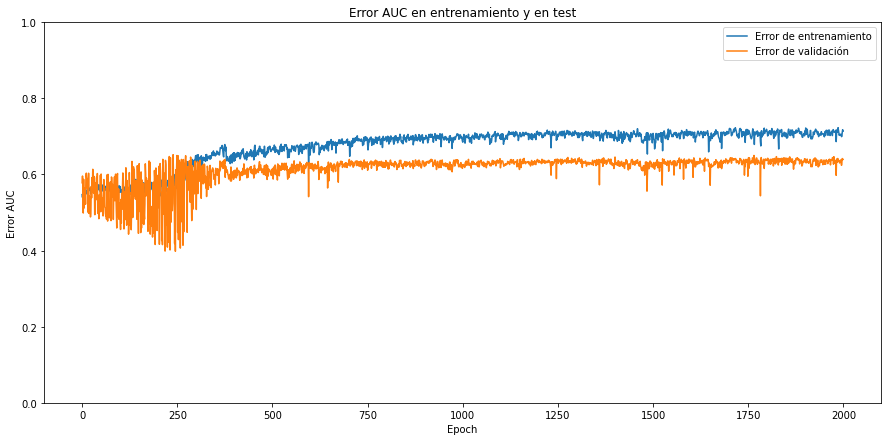

In [ ]:
plt.figure(figsize=(15,7))
plt.xlabel('Epoch')
plt.ylabel('Error AUC')
plt.plot(hist['epoch'], hist['auc'],
    label='Error de entrenamiento')
plt.plot(hist['epoch'], hist['val_auc'],
    label = 'Error de validación')
plt.title('Error AUC en entrenamiento y en test')
plt.ylim([0,1])
plt.legend()


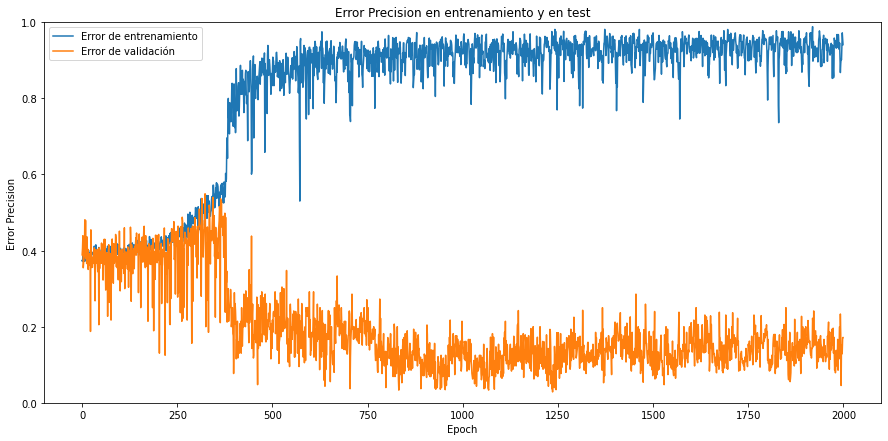

In [ ]:
plt.figure(figsize=(15,7))
plt.xlabel('Epoch')
plt.ylabel('Error Precision')
plt.plot(hist['epoch'], hist['precision'],
    label='Error de entrenamiento')
plt.plot(hist['epoch'], hist['val_precision'],
    label = 'Error de validación')
plt.title('Error Precision en entrenamiento y en test')
plt.ylim([0,1])
plt.legend()
plt.show()


......................................

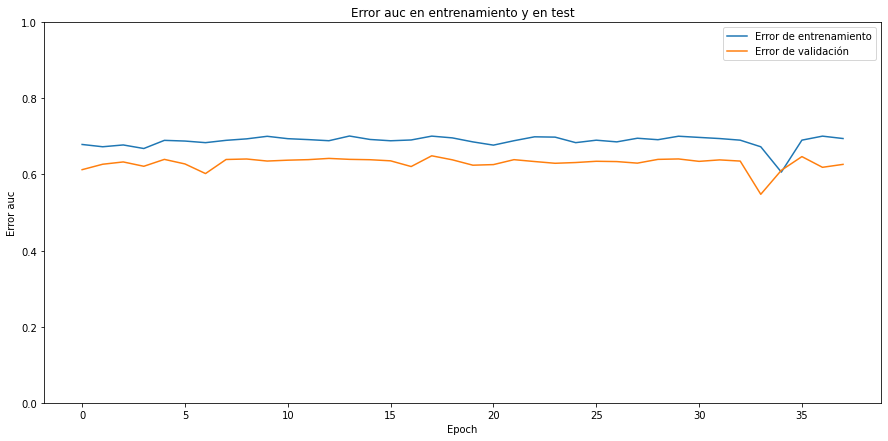

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_auc', patience=20, mode='max')

history = modelo4.fit(X_train, Y_train,
                    epochs=EPOCHS,
                    validation_split = 0.2,
                    verbose=0,
                    callbacks=[early_stop, PrintDot()])

represento_historico(history)

In [ ]:
y_test_pred_prob = modelo4.predict(X_test)
y_test_pred_prob_pos = y_test_pred_prob[np.where(Y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(Y_test == 0)[0]]

91/91 [==============================] - 0s 2ms/step


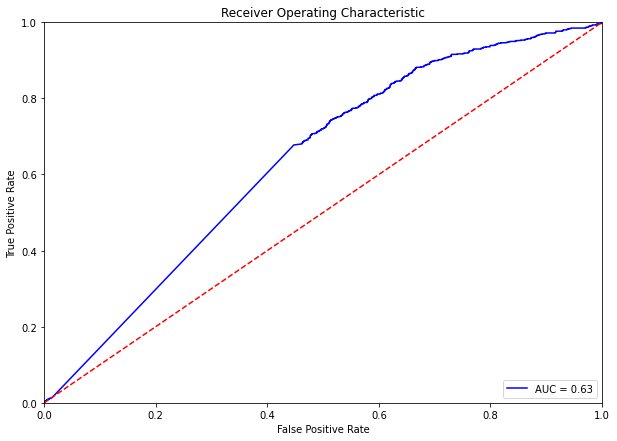

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(Y_test, abs(y_test_pred_prob))
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Umbralizo las predicciones:

In [ ]:
umbral = 0.6
y_umbralizadas = 1*abs(y_test_pred_prob) > umbral


Accuracy	0.7
Sensitividad	0.01
Precisión	0.3


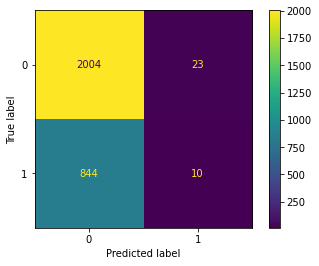

In [ ]:
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2)))
metrics.ConfusionMatrixDisplay.from_predictions(Y_test, y_umbralizadas)
plt.show()


Accuracy	0.7
Sensitividad	0.01
Precisión	0.32


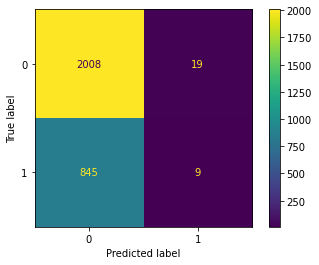

In [ ]:
umbral = 0.8
y_umbralizadas = 1*abs(y_test_pred_prob) > umbral
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2)))
metrics.ConfusionMatrixDisplay.from_predictions(Y_test, y_umbralizadas)
plt.show()


Accuracy	0.59
Sensitividad	0.68
Precisión	0.39


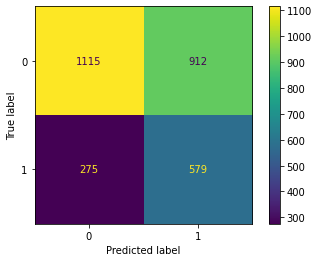

In [ ]:
umbral = 0.4
y_umbralizadas = 1*abs(y_test_pred_prob) > umbral
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2)))
metrics.ConfusionMatrixDisplay.from_predictions(Y_test, y_umbralizadas)
plt.show()


Accuracy	0.7
Sensitividad	0.01
Precisión	0.28


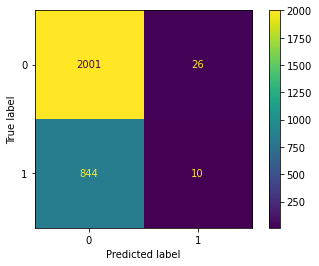

In [ ]:
umbral = 0.5
y_umbralizadas = 1*abs(y_test_pred_prob) > umbral
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2)))
metrics.ConfusionMatrixDisplay.from_predictions(Y_test, y_umbralizadas)
plt.show()

#APLICACIÓN DE ALGORITMO DE CLASIFICACIÓN AL CLÚSTER 1

In [ ]:
XY3

,MB_TOTALES,FACTURACION_TOTAL_IMPUESTOS,FACTURACION_CUOTA,SEGUNDOS_LLAMADA_RED_PROPIA,SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,EDAD,NUM_LLAMADAS_RED_PROPIA,NUM_LINEAS_PRIN_POSPAGO,NUM_LINEAS_POSPAGO,...,NUM_DESACTIVACIONES,PORCENTAJE_SEGUNDOS_RED_PROPIA,SERVICIOS_TOTALES_MARCA,SERVICIOS_TOTALES_POSPAGO,MINUTOS_LLAMADAS_MOVIL,PENETRACION_FIJO_ZONA,ESTACION_Otoño,ESTACION_Primavera,ESTACION_Verano,target
2,2141.692810,37.442001,31.400000,13.0,13.0,0.0,47.0,4.0,2,2,...,0,100.0,2,2,0.0,0.156041,0,1,0,0
3,3181.986496,20.001000,16.530000,0.0,0.0,0.0,43.0,0.0,1,2,...,0,100.0,2,3,0.0,0.228810,0,1,0,1
5,3315.026978,45.991000,33.049999,9074.0,5171.0,74.0,39.0,236.0,1,3,...,0,100.0,3,3,0.0,0.199451,0,1,0,0
8,16920.810547,28.798001,26.450001,581.0,66.0,5.0,36.0,10.0,1,1,...,0,100.0,1,1,0.0,0.299551,0,1,0,0
12,673.515686,13.003000,9.920000,2685.0,0.0,9.0,51.0,9.0,1,1,...,0,100.0,1,1,0.0,0.380171,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19974,23012.503906,38.007001,26.450001,6314.0,3606.0,29.0,26.0,70.0,1,1,...,0,100.0,1,2,0.0,0.143134,0,1,0,0
19986,58695.895264,95.267001,53.639999,62520.0,40226.0,116.0,45.0,321.0,2,2,...,0,100.0,2,3,0.0,0.256870,0,1,0,0
19988,1457.444336,57.517002,22.309999,699.0,74.0,2.0,40.0,7.0,1,1,...,0,100.0,1,1,0.0,0.210286,0,1,0,0
19991,0.000000,11.170000,0.000000,5687.0,2501.0,13.0,56.0,23.0,1,1,...,0,100.0,1,1,0.0,0.292565,0,1,0,0


In [ ]:
XY3['target'].value_counts()

0    3589
1    1699
Name: target, dtype: int64

In [ ]:
X3 = XY3.drop('target', axis=1)
Y3 = XY3['target']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X3, Y3, test_size=0.2, random_state=0)

In [ ]:
X_train.shape[0]

4230

In [ ]:
X_train.shape[1]

35



##Aplicamos un modelo de regresión logística

Optimizando C y class_weight con GridSearch

In [ ]:
modelo = LogisticRegression()
parametros = {"C": [0., 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08,0.09],
              "class_weight":['balanced', None]}

Con GridSearchCV se realiza una optimización. Esta función lo que hace es ajustar el modelo que se pasa como argumento con todas las combinaciones posibles de los parámetros. En este caso, todas las combinaciones de C y class_weights.

In [ ]:
modelo_gs = GridSearchCV(modelo, param_grid=parametros,
                         cv = 5, scoring='roc_auc')
modelo_gs.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,
                               0.08, 0.09],
                         'class_weight': ['balanced', None]},
             scoring='roc_auc')

In [ ]:
GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,
                               0.08, 0.09],
                         'class_weight': ['balanced', None]},
             scoring='roc_auc')

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,
                               0.08, 0.09],
                         'class_weight': ['balanced', None]},
             scoring='roc_auc')

In [ ]:
print(modelo_gs.best_params_, "\nROC AUC: {}".format(round(modelo_gs.best_score_,2)))

{'C': 0.01, 'class_weight': 'balanced'} 
ROC AUC: 0.65


In [ ]:
df_search = pd.DataFrame.from_dict(modelo_gs.cv_results_)

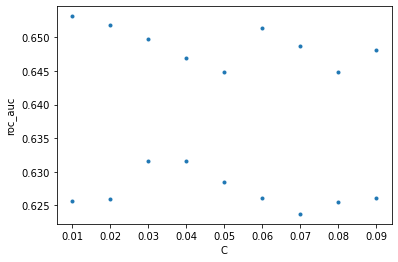

In [ ]:
plt.xlabel('C')
plt.ylabel('roc_auc')
_ = plt.plot( df_search['param_C'], df_search['mean_test_score'], '.')

##Analizando el modelo con el mejor alpha

En este paso nos quedamos con los mejores parámetros obtenidos en el paso anterior:

In [ ]:
reg_log =  LogisticRegression(C=modelo_gs.best_params_['C'],
                              class_weight=modelo_gs.best_params_['class_weight'])

In [ ]:
reg_log.fit(X_train, Y_train)

LogisticRegression(C=0.01, class_weight='balanced')

Ahora uso el Test para validar el modelo ya optimizado.



In [ ]:
y_test_pred_prob = reg_log.predict_proba(X_test)
y_test_pred_prob_pos = y_test_pred_prob[np.where(Y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(Y_test == 0)[0]]

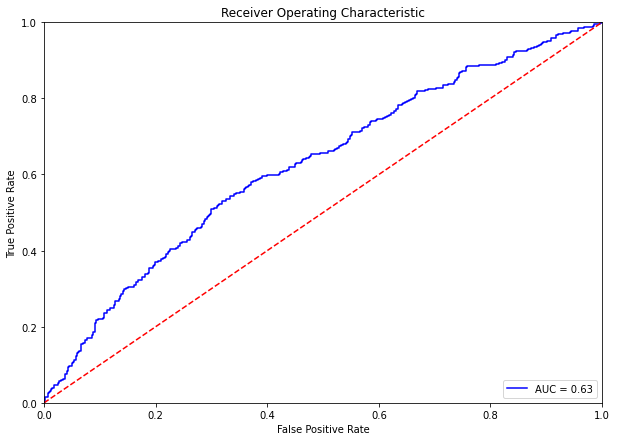

In [ ]:
preds = y_test_pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

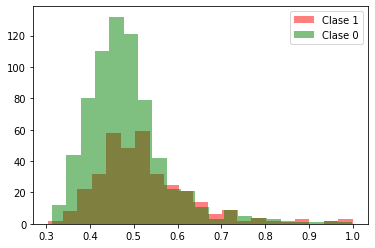

In [ ]:
represento_doble_hist(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], n_bins=21, normed=0)

##Umbralizo las predicciones:

Las probabilidades que devuelve el modelo son valores continuos entre 0 y 1. Para pasarlo a 0s y a 1s es necesario usar un umbral de corte. Todo lo que sea mayor que el umbral será predicción = 1, y lo que sea menor será predicción = 0.

In [ ]:
umbral = 0.5
y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)


Accuracy	0.63
Sensitividad	0.54
Precisión	0.45


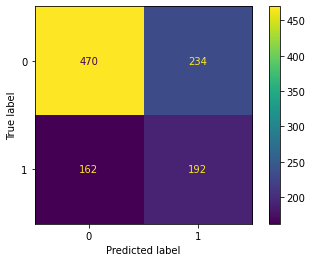

In [ ]:
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2)))
metrics.ConfusionMatrixDisplay.from_predictions(Y_test, y_umbralizadas)
plt.show()

In [ ]:
umbral = 0.8
y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)


Accuracy	0.67
Sensitividad	0.03
Precisión	0.57


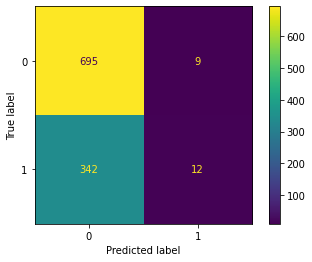

In [ ]:
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2)))
metrics.ConfusionMatrixDisplay.from_predictions(Y_test, y_umbralizadas)
plt.show()

In [ ]:
umbral = 0.3
y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)


Accuracy	0.33
Sensitividad	1.0
Precisión	0.33


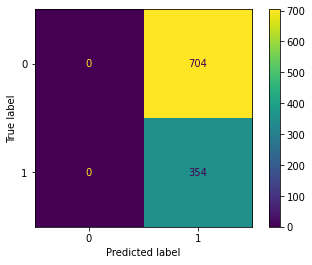

In [ ]:
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2)))
metrics.ConfusionMatrixDisplay.from_predictions(Y_test, y_umbralizadas)
plt.show()

In [ ]:
umbral = 0.7
y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)


Accuracy	0.67
Sensitividad	0.08
Precisión	0.5


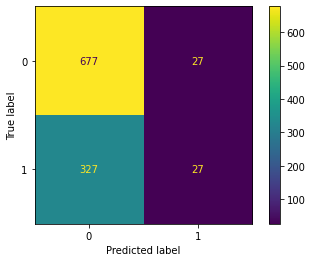

In [ ]:
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2)))
metrics.ConfusionMatrixDisplay.from_predictions(Y_test, y_umbralizadas)
plt.show()

#APLICACIÓN DE ALGORITMO DE CLASIFICACIÓN AL CLÚSTER 1

Usamos algoritmo Random Forest, con optimización primero por RandomizedSearchCV y después con GridSearchCV.

In [ ]:
XY3

,MB_TOTALES,FACTURACION_TOTAL_IMPUESTOS,FACTURACION_CUOTA,SEGUNDOS_LLAMADA_RED_PROPIA,SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,EDAD,NUM_LLAMADAS_RED_PROPIA,NUM_LINEAS_PRIN_POSPAGO,NUM_LINEAS_POSPAGO,...,NUM_DESACTIVACIONES,PORCENTAJE_SEGUNDOS_RED_PROPIA,SERVICIOS_TOTALES_MARCA,SERVICIOS_TOTALES_POSPAGO,MINUTOS_LLAMADAS_MOVIL,PENETRACION_FIJO_ZONA,ESTACION_Otoño,ESTACION_Primavera,ESTACION_Verano,target
2,2141.692810,37.442001,31.400000,13.0,13.0,0.0,47.0,4.0,2,2,...,0,100.0,2,2,0.0,0.156041,0,1,0,0
3,3181.986496,20.001000,16.530000,0.0,0.0,0.0,43.0,0.0,1,2,...,0,100.0,2,3,0.0,0.228810,0,1,0,1
5,3315.026978,45.991000,33.049999,9074.0,5171.0,74.0,39.0,236.0,1,3,...,0,100.0,3,3,0.0,0.199451,0,1,0,0
8,16920.810547,28.798001,26.450001,581.0,66.0,5.0,36.0,10.0,1,1,...,0,100.0,1,1,0.0,0.299551,0,1,0,0
12,673.515686,13.003000,9.920000,2685.0,0.0,9.0,51.0,9.0,1,1,...,0,100.0,1,1,0.0,0.380171,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19974,23012.503906,38.007001,26.450001,6314.0,3606.0,29.0,26.0,70.0,1,1,...,0,100.0,1,2,0.0,0.143134,0,1,0,0
19986,58695.895264,95.267001,53.639999,62520.0,40226.0,116.0,45.0,321.0,2,2,...,0,100.0,2,3,0.0,0.256870,0,1,0,0
19988,1457.444336,57.517002,22.309999,699.0,74.0,2.0,40.0,7.0,1,1,...,0,100.0,1,1,0.0,0.210286,0,1,0,0
19991,0.000000,11.170000,0.000000,5687.0,2501.0,13.0,56.0,23.0,1,1,...,0,100.0,1,1,0.0,0.292565,0,1,0,0


In [ ]:
X3 = XY3.drop('target', axis=1)
Y3 = XY3['target']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X3, Y3, test_size=0.2, random_state=0)

In [ ]:
rf_model = RandomForestClassifier()

In [ ]:
distributions = dict(n_estimators=[2, 5, 7, 10,50,100,150], # uniforme en [loc, loc + scale]
                     max_depth=[3, 5, 7, 12, 20])

In [ ]:
clf = RandomizedSearchCV(rf_model, distributions, random_state=0, n_iter=10, scoring='roc_auc_ovr_weighted')

In [ ]:
search = clf.fit(X_train, Y_train)
search.best_params_

{'n_estimators': 150, 'max_depth': 7}

In [ ]:
search.cv_results_['mean_test_score']

array([0.59002596, 0.68795397, 0.67293655, 0.56372018, 0.63359641,
       0.65722008, 0.6775792 , 0.67188122, 0.68501221, 0.67960673])

In [ ]:
df_search = pd.DataFrame.from_dict(search.cv_results_)

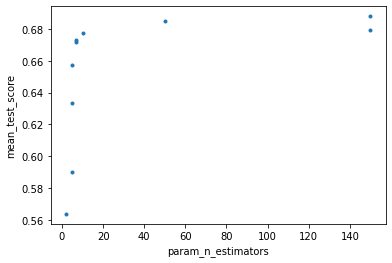

In [ ]:
plt.xlabel('param_n_estimators')
plt.ylabel('mean_test_score')
_ = plt.plot( df_search['param_n_estimators'], df_search['mean_test_score'], '.')

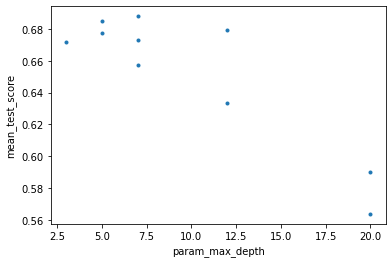

In [ ]:
plt.xlabel('param_max_depth')
plt.ylabel('mean_test_score')
_ = plt.plot( df_search['param_max_depth'], df_search['mean_test_score'], '.')

In [ ]:
grid = {"max_depth":[3, 5, 7, 9],
        "n_estimators": [150, 200, 300]}
clf = GridSearchCV(rf_model, param_grid = grid, scoring='roc_auc_ovr_weighted')
search = clf.fit(X_train, Y_train)
search.best_params_

{'max_depth': 7, 'n_estimators': 300}

In [ ]:
df_search = pd.DataFrame.from_dict(search.cv_results_)
df_search

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.511659,0.016622,0.032786,0.002997,3,150,"{'max_depth': 3, 'n_estimators': 150}",0.664687,0.702274,0.684492,0.666594,0.687256,0.681060,0.013982,12
1,0.665040,0.019203,0.040691,0.002308,3,200,"{'max_depth': 3, 'n_estimators': 200}",0.664977,0.703169,0.683145,0.667463,0.688596,0.681470,0.014090,11
2,1.228756,0.248169,0.071013,0.014531,3,300,"{'max_depth': 3, 'n_estimators': 300}",0.666748,0.705418,0.682971,0.668849,0.687829,0.682363,0.014059,10
3,0.669626,0.045954,0.035511,0.004887,5,150,"{'max_depth': 5, 'n_estimators': 150}",0.665337,0.709773,0.687056,0.674248,0.692655,0.685814,0.015333,6
4,0.848895,0.012168,0.045568,0.005822,5,200,"{'max_depth': 5, 'n_estimators': 200}",0.665447,0.711339,0.684769,0.673230,0.691753,0.685307,0.015873,7
5,1.294899,0.010786,0.062757,0.003014,5,300,"{'max_depth': 5, 'n_estimators': 300}",0.668662,0.711068,0.685007,0.676354,0.691514,0.686521,0.014506,5
6,0.790846,0.009529,0.035882,0.001305,7,150,"{'max_depth': 7, 'n_estimators': 150}",0.669151,0.710926,0.682204,0.678107,0.695264,0.687131,0.014569,2
7,1.063391,0.014695,0.048648,0.002373,7,200,"{'max_depth': 7, 'n_estimators': 200}",0.668984,0.708175,0.684247,0.680169,0.692706,0.686856,0.013112,4
8,1.548707,0.020686,0.069282,0.003282,7,300,"{'max_depth': 7, 'n_estimators': 300}",0.665911,0.712717,0.684620,0.679209,0.695535,0.687598,0.015771,1
9,0.898236,0.012825,0.039907,0.001719,9,150,"{'max_depth': 9, 'n_estimators': 150}",0.670517,0.708091,0.673088,0.673803,0.686489,0.682398,0.013990,9


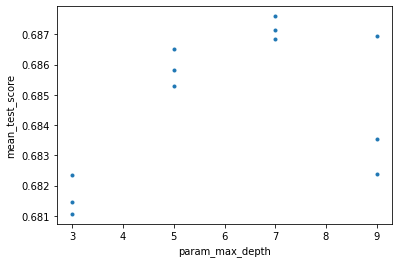

In [ ]:
plt.xlabel('param_max_depth')
plt.ylabel('mean_test_score')
_ = plt.plot( df_search['param_max_depth'], df_search['mean_test_score'], '.')

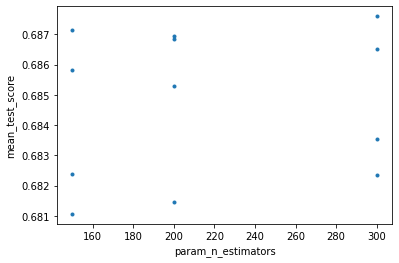

In [ ]:
plt.xlabel('param_n_estimators')
plt.ylabel('mean_test_score')
_ = plt.plot( df_search['param_n_estimators'], df_search['mean_test_score'], '.')

In [ ]:
y_test_pred_prob = reg_log.predict_proba(X_test)
y_test_pred_prob_pos = y_test_pred_prob[np.where(Y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(Y_test == 0)[0]]

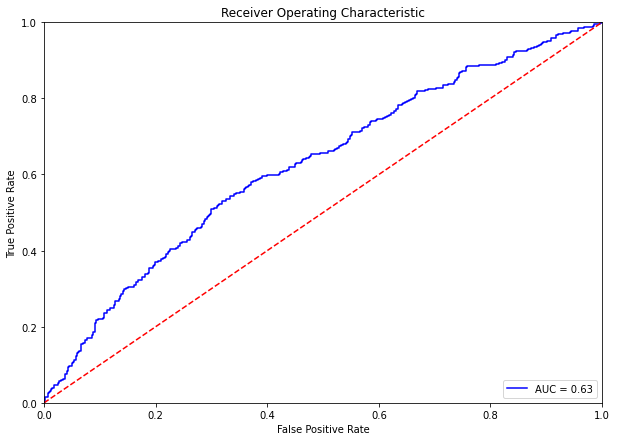

In [ ]:
preds = y_test_pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#Umbralizo las predicciones:

In [ ]:
umbral = 0.5
y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)


Accuracy	0.63
Sensitividad	0.54
Precisión	0.45


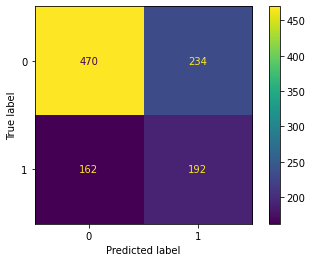

In [ ]:
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2)))
metrics.ConfusionMatrixDisplay.from_predictions(Y_test, y_umbralizadas)
plt.show()

In [ ]:
umbral = 0.3
y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)


Accuracy	0.33
Sensitividad	1.0
Precisión	0.33


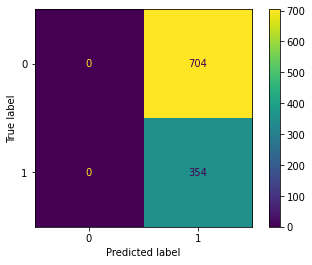

In [ ]:
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2)))
metrics.ConfusionMatrixDisplay.from_predictions(Y_test, y_umbralizadas)
plt.show()

In [ ]:
umbral = 0.8
y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)


Accuracy	0.67
Sensitividad	0.03
Precisión	0.57


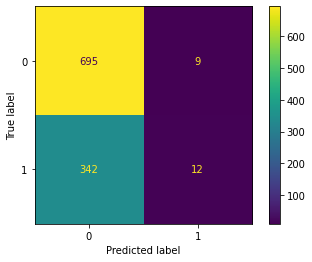

In [ ]:
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2)))
metrics.ConfusionMatrixDisplay.from_predictions(Y_test, y_umbralizadas)
plt.show()